# Imports

In [1]:
import pickle
import torch
import random
import math
import h5py
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from torchvision import models, transforms
from torchvision.utils import make_grid
from torchsummary import summary
from torchvision.transforms import v2
from google.colab import drive
from google.colab import runtime
from PIL import Image
!pip install torchinfo
!pip install tensorboard
from torchinfo import summary
drive.mount('/content/drive')

Mounted at /content/drive


# Data

File Loading

In [2]:
# Load training data from HDF5 file
with h5py.File('/content/drive/My Drive/AV Research/train_data.h5', 'r') as train_file:
    train_data = np.array(train_file['data'])
    train_labels = np.array(train_file['labels'])

# Load validation data from HDF5 file
with h5py.File('/content/drive/My Drive/AV Research/val_data.h5', 'r') as val_file:
    val_data = np.array(val_file['data'])
    val_labels = np.array(val_file['labels'])

In [3]:
# From: https://stackoverflow.com/questions/60101240/finding-mean-and-standard-deviation-across-image-channels-pytorch
def dataset_mean_std(data_loader):
  nimages = 0
  mean = 0.
  std = 0.
  for batch, _ in data_loader:
      # Rearrange batch to be the shape of [B, C, W * H]
      batch = batch.view(batch.size(0), batch.size(1), -1)
      # Update total number of images
      nimages += batch.size(0)
      # Compute mean and std here
      mean += batch.float().mean(2).sum(0)
      std += batch.float().std(2).sum(0)

  # Final step
  mean /= nimages
  std /= nimages

  print("Training set mean", mean)
  print("Training set std", std)

  return mean, std

def get_mean_std(data):
  mean = np.mean(data, axis=(0, 1, 2))
  std = np.std(data, axis=(0, 1, 2))
  return mean, std

Data Transformations

In [4]:
class RandomHorizontalFlipWithSteeringAngle(object):
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, input, output):
        if random.random() < self.p:
            v2.functional.hflip(input)
            output[0] = -output[0]
        return input, output

class TrainDataAugmentation(nn.Module):
    def __init__(self):
        super(TrainDataAugmentation, self).__init__()
        self.transforms = v2.Compose([
            v2.Resize((119//2, 256//2)),
            v2.ToImage(),
            v2.RandomAffine(degrees=0, translate=(0.2, 0.2)),
            v2.RandomRotation(degrees=45),
            v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize(mean=(0.4872, 0.4669, 0.4469,), std=(0.1138, 0.1115, 0.1074,)),
        ])

    def forward(self, image):
        augmented_image = self.transforms(image)
        return augmented_image

class ValDataAugmentation(nn.Module):
    def __init__(self):
        super(ValDataAugmentation, self).__init__()
        self.transforms = v2.Compose([
            v2.Resize((119//2, 256//2)),
            v2.ToImage(),
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize(mean=(0.4872, 0.4669, 0.4469,), std=(0.1138, 0.1115, 0.1074,)),
        ])

    def forward(self, image):
        augmented_image = self.transforms(image)
        return augmented_image

Data Preprocessing

In [5]:
class AVDataset(Dataset):
    def __init__(self, input_images, output_values, transform):
        self.input_images = input_images
        self.output_values = output_values
        self.transform = transform

    def __len__(self):
        return len(self.output_values)

    def __getitem__(self, idx):
        input_image = self.input_images[idx]
        output_value = self.output_values[idx]

        if self.transform:
            input_image = self.transform(input_image)
            input_image, output_value = RandomHorizontalFlipWithSteeringAngle(0.5)(input_image, output_value)

        return input_image, output_value

train_data_augmentation = TrainDataAugmentation()
val_data_augmentation = ValDataAugmentation()

train_dataset = AVDataset(input_images=train_data, output_values=train_labels, transform=train_data_augmentation)
val_dataset = AVDataset(input_images=val_data, output_values=val_labels, transform=val_data_augmentation)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=1, pin_memory=True)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


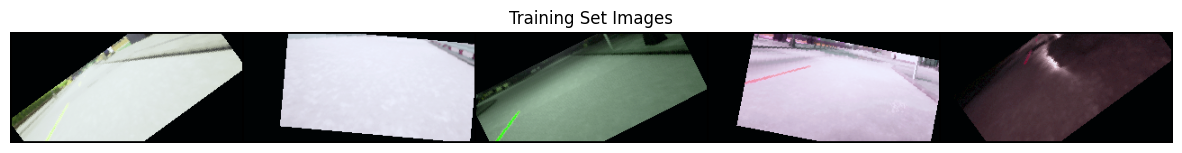

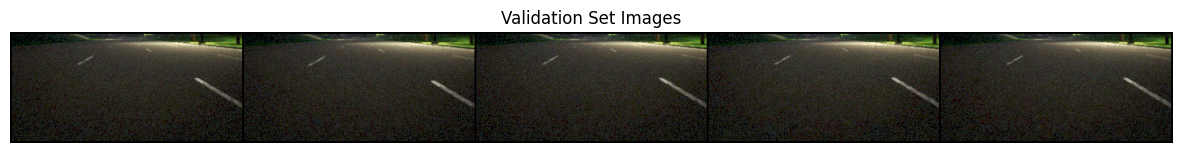

In [6]:
def show_images(images, nrow=5, title=None):
    grid = make_grid(images, nrow=nrow, normalize=True, scale_each=True)
    npimg = grid.numpy()
    plt.figure(figsize=(15, 6))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

def plot_images_from_loader(loader, title):
    # Get a batch of images
    dataiter = iter(loader)
    images, _ = next(dataiter)
    batch_size = images.shape[0]

    # Select 5 random indices
    random_indices = random.sample(range(batch_size), 5)
    random_images = images[random_indices]

    # Call the helper function to show images
    show_images(random_images, title=title)


# Assuming train_loader and val_loader are defined
plot_images_from_loader(train_loader, title="Training Set Images")
plot_images_from_loader(val_loader, title="Validation Set Images")

# Model

Neural Network

In [7]:
# From: https://github.com/wzlxjtu/PositionalEncoding2D
class PositionalEncoding2d(nn.Module):
    def __init__(self, d_model, height, width):
        super(PositionalEncoding2d, self).__init__()
        if d_model % 4 != 0:
            raise ValueError("Cannot use sin/cos positional encoding with "
                            "odd dimension (got dim={:d})".format(d_model))
        pe = torch.zeros(d_model, height, width)
        # Each dimension use half of d_model
        d_model = int(d_model / 2)
        div_term = torch.exp(torch.arange(0., d_model, 2) *
                            -(math.log(10000.0) / d_model))
        pos_w = torch.arange(0., width).unsqueeze(1)
        pos_h = torch.arange(0., height).unsqueeze(1)
        pe[0:d_model:2, :, :] = torch.sin(pos_w * div_term).transpose(0, 1).unsqueeze(1).repeat(1, height, 1)
        pe[1:d_model:2, :, :] = torch.cos(pos_w * div_term).transpose(0, 1).unsqueeze(1).repeat(1, height, 1)
        pe[d_model::2, :, :] = torch.sin(pos_h * div_term).transpose(0, 1).unsqueeze(2).repeat(1, 1, width)
        pe[d_model + 1::2, :, :] = torch.cos(pos_h * div_term).transpose(0, 1).unsqueeze(2).repeat(1, 1, width)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe

In [8]:
# Inspired by: https://github.com/reshalfahsi/separableconv-torch
class SeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, bias):
        super(SeparableConv2d, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, stride=stride, padding=padding, groups=in_channels, bias=bias)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

class ResidualBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int, num_layers: int, pool: bool, short: bool):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.pooling = pool
        self.short = short

        self.inconv = nn.Sequential(
            SeparableConv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=1, padding=1, bias=False),
            nn.SELU()
        )

        layers = []
        for _ in range(num_layers - 1):
            layers.append(SeparableConv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size, stride=1, padding=1, bias=False))
            layers.append(nn.SELU())
        self.convlayers = nn.Sequential(*layers)

        if self.pooling:
            self.pool = nn.MaxPool2d(kernel_size=kernel_size, stride=2, padding=1)
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2, bias=False)
        else:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)

        self.sact = nn.SELU()

    def forward(self, x):
        out = self.inconv(x)
        out = self.convlayers(out)

        if self.pooling:
            out = self.pool(out)

        if self.short:
            shortcut = self.shortcut(x)
            out = out + shortcut
            out = self.sact(out)

        return out

In [19]:
class AVModel(nn.Module):
    def __init__(self):
        super(AVModel, self).__init__()
        self.conv1 = SeparableConv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False)
        self.norm = nn.LayerNorm(64)
        self.attention = nn.MultiheadAttention(embed_dim=64, num_heads=1, dropout=0.5, batch_first=True)
        self.scale = nn.Parameter(torch.zeros(1))
        self.act = nn.SELU()

        self.conv_layers = nn.Sequential(
            ResidualBlock(in_channels=64, out_channels=64, kernel_size=3, num_layers=3, pool=True, short=True),
            ResidualBlock(in_channels=64, out_channels=128, kernel_size=3, num_layers=4, pool=True, short=True),
            ResidualBlock(in_channels=128, out_channels=256, kernel_size=3, num_layers=4, pool=True, short=True),
            nn.Dropout2d(0.5),
        )

        self.dense_layers = nn.Sequential(
            nn.Linear(256, 128, bias=False),
            nn.SELU(),
            nn.Dropout(0.5),
        )

        self.output_layer = nn.Linear(128, 3)

    def forward(self, x):
        x = self.conv1(x)
        # batch_size, channels, height, width = x.size()
        # x_att = x.reshape(batch_size, channels, height * width).transpose(1, 2)
        # x_att = self.norm(x_att)
        # attention_output, _ = self.attention(x_att, x_att, x_att)
        # attention_output = attention_output.transpose(1, 2).reshape(batch_size, channels, height, width)
        # x = self.scale * attention_output + x
        x = self.act(x)

        x = self.conv_layers(x)
        x = torch.mean(x.view(x.size(0), x.size(1), -1), dim=2) # GlobalAveragePooling2D
        x = self.dense_layers(x)
        out = self.output_layer(x)

        # steering_output = F.hardtanh(x[:, 0:1])
        # throttle_brake_output = F.hardtanh(x[:, 1:], min_val=0)
        # out = torch.cat((steering_output, throttle_brake_output), dim=1)
        return out

In [10]:
class SimpleAVModel(nn.Module):
    def __init__(self):
        super(SimpleAVModel, self).__init__()
        self.conv_layers = nn.Sequential(
            SeparableConv2d(in_channels=3, out_channels=24, kernel_size=3, stride=2, padding=1, bias=False),
            nn.ELU(),
            SeparableConv2d(in_channels=24, out_channels=48, kernel_size=3, stride=2, padding=1, bias=False),
            nn.MaxPool2d(kernel_size=4, stride=4, padding=1),
            nn.Dropout(0.25)
        )

        self.dense_layers = nn.Sequential(
            nn.Linear(1536, 50, bias=False),
            nn.ELU(),
            nn.Linear(50, 10, bias=False),
        )

        self.output_layer = nn.Linear(10, 3)

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.dense_layers(x)
        out = self.output_layer(x)
        return out

# Util

MFPE Loss

In [11]:
class MFPELoss(nn.Module):
    def __init__(self):
        super(MFPELoss, self).__init__()

    def forward(self, input, target):
        error = input - target
        fourth_power_error = error ** 4
        mean_fourth_power_error = torch.mean(fourth_power_error)
        return mean_fourth_power_error

Early Stopping

In [12]:
class EarlyStopping:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

Autoclip

In [13]:
# From: https://github.com/pseeth/autoclip/blob/master/autoclip.py
class AutoClip:
    def __init__(self, percentile):
        self.grad_history = []
        self.percentile = percentile

    def compute_grad_norm(self, model):
        total_norm = 0
        for p in model.parameters():
            if p.grad is not None:
                param_norm = p.grad.data.norm(2)
                total_norm += param_norm.item() ** 2
        total_norm = total_norm ** (1. / 2)

        return total_norm

    def __call__(self, model):
        grad_norm = self.compute_grad_norm(model)
        self.grad_history.append(grad_norm)
        clip_value = np.percentile(self.grad_history, self.percentile)
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)

Model Checkpoint

In [14]:
def save_checkpoint(model, optimizer, scheduler, num_epochs, train_losses, val_losses):
  checkpoint = {
          'epoch': num_epochs + 1,
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'scheduler_state_dict': scheduler.state_dict(),
          'train_losses': train_losses,
          'val_losses': val_losses,
      }
  torch.save(checkpoint, '/content/drive/My Drive/AV Research/new_model_checkpoint.pt')

# Training Loop

In [21]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = AVModel().to(device)
num_epochs = 30
learning_rate = 1e-5
criterion = MFPELoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)
scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer=optimizer, T_0=(num_epochs // 5))
early_stopping = EarlyStopping(patience=5)

torch.autograd.set_detect_anomaly(False)
torch.backends.cudnn.benchmark = True
scaler = torch.cuda.amp.GradScaler()
autoclipper = AutoClip(percentile=10)

writer = SummaryWriter()

train_losses = []
val_losses = []

print(summary(model, input_size=(batch_size, 3, 119 // 2, 256 // 2)))

def train_loop(train_loader, model, criterion, optimizer, device):
    size = len(train_loader.dataset)
    model.train()
    train_loss = 0.0
    num_batches = len(train_loader)

    # Training loop
    for batch, (inputs, targets) in enumerate(tqdm(train_loader)):
        optimizer.zero_grad()
        inputs = inputs.float().to(device)
        targets = targets.float().to(device)
        with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
          outputs = model(inputs)
          loss = criterion(outputs, targets)

        train_loss += loss.item()
        scaler.scale(loss).backward()
        autoclipper(model)

        scaler.step(optimizer)
        scale = scaler.get_scale()
        scaler.update()
        skip_lr_sched = (scale != scaler.get_scale())

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(inputs)
            print(f"Training loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    train_loss = train_loss / num_batches
    return train_loss, skip_lr_sched

def val_loop(val_loader, model, criterion, device):
    model.eval()
    val_loss = 0.0
    num_batches = len(val_loader)

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.float().to(device, non_blocking=True)
            targets = targets.float().to(device, non_blocking=True)
            outputs = model(inputs)
            val_loss += criterion(outputs, targets).item()

    val_loss = val_loss / num_batches
    return val_loss

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_loss, skip_lr_sched = train_loop(train_loader, model, criterion, optimizer, device)
    val_loss = val_loop(val_loader, model, criterion, device)
    print(f"Train loss: {train_loss:>8f} - Val loss: {val_loss:>8f} \n")

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('Loss/val', val_loss, epoch)

    save_checkpoint(model, optimizer, scheduler, epoch, train_losses, val_losses)

    # if early_stopping.early_stop(val_loss):
    #     print(f"Early stopping after {epoch+1} epochs \n")
    #     print(f"Best val loss: {early_stopping.min_validation_loss} \n")
    #     break

    if not skip_lr_sched:
        scheduler.step()

writer.close()

Layer (type:depth-idx)                        Output Shape              Param #
AVModel                                       [32, 3]                   16,769
├─SeparableConv2d: 1-1                        [32, 64, 59, 128]         --
│    └─Conv2d: 2-1                            [32, 3, 59, 128]          27
│    └─Conv2d: 2-2                            [32, 64, 59, 128]         192
├─SELU: 1-2                                   [32, 64, 59, 128]         --
├─Sequential: 1-3                             [32, 256, 8, 16]          --
│    └─ResidualBlock: 2-3                     [32, 64, 30, 64]          --
│    │    └─Sequential: 3-1                   [32, 64, 59, 128]         4,672
│    │    └─Sequential: 3-2                   [32, 64, 59, 128]         9,344
│    │    └─MaxPool2d: 3-3                    [32, 64, 30, 64]          --
│    │    └─Conv2d: 3-4                       [32, 64, 30, 64]          4,096
│    │    └─SELU: 3-5                         [32, 64, 30, 64]          --
│    └

  0%|          | 2/4350 [00:00<22:52,  3.17it/s]

Training loss: 0.188076  [   32/139199]


  2%|▏         | 101/4350 [00:23<16:32,  4.28it/s]

Training loss: 0.087172  [ 3232/139199]


  5%|▍         | 201/4350 [00:45<15:41,  4.41it/s]

Training loss: 0.061382  [ 6432/139199]


  7%|▋         | 301/4350 [01:08<15:03,  4.48it/s]

Training loss: 0.072545  [ 9632/139199]


  9%|▉         | 401/4350 [01:30<14:32,  4.53it/s]

Training loss: 0.053787  [12832/139199]


 12%|█▏        | 501/4350 [01:53<14:21,  4.47it/s]

Training loss: 0.043998  [16032/139199]


 14%|█▍        | 601/4350 [02:16<14:25,  4.33it/s]

Training loss: 0.054678  [19232/139199]


 16%|█▌        | 701/4350 [02:40<13:38,  4.46it/s]

Training loss: 0.052884  [22432/139199]


 18%|█▊        | 801/4350 [03:03<13:22,  4.42it/s]

Training loss: 0.036036  [25632/139199]


 21%|██        | 901/4350 [03:26<13:46,  4.17it/s]

Training loss: 0.033001  [28832/139199]


 23%|██▎       | 1001/4350 [03:50<14:10,  3.94it/s]

Training loss: 0.049041  [32032/139199]


 25%|██▌       | 1101/4350 [04:13<12:35,  4.30it/s]

Training loss: 0.036506  [35232/139199]


 28%|██▊       | 1201/4350 [04:37<11:57,  4.39it/s]

Training loss: 0.041435  [38432/139199]


 30%|██▉       | 1301/4350 [05:00<11:50,  4.29it/s]

Training loss: 0.039311  [41632/139199]


 32%|███▏      | 1401/4350 [05:23<11:13,  4.38it/s]

Training loss: 0.027096  [44832/139199]


 35%|███▍      | 1501/4350 [05:47<11:11,  4.25it/s]

Training loss: 0.028804  [48032/139199]


 37%|███▋      | 1601/4350 [06:10<10:26,  4.39it/s]

Training loss: 0.041814  [51232/139199]


 39%|███▉      | 1701/4350 [06:33<10:06,  4.37it/s]

Training loss: 0.031495  [54432/139199]


 41%|████▏     | 1801/4350 [06:57<10:06,  4.21it/s]

Training loss: 0.034733  [57632/139199]


 44%|████▎     | 1901/4350 [07:21<09:29,  4.30it/s]

Training loss: 0.036243  [60832/139199]


 46%|████▌     | 2001/4350 [07:45<09:03,  4.32it/s]

Training loss: 0.031159  [64032/139199]


 48%|████▊     | 2101/4350 [08:09<09:23,  3.99it/s]

Training loss: 0.035037  [67232/139199]


 51%|█████     | 2201/4350 [08:33<08:38,  4.15it/s]

Training loss: 0.032294  [70432/139199]


 53%|█████▎    | 2301/4350 [08:57<08:28,  4.03it/s]

Training loss: 0.032201  [73632/139199]


 55%|█████▌    | 2401/4350 [09:22<08:02,  4.04it/s]

Training loss: 0.032672  [76832/139199]


 57%|█████▋    | 2501/4350 [09:46<07:47,  3.96it/s]

Training loss: 0.028751  [80032/139199]


 60%|█████▉    | 2601/4350 [10:10<07:09,  4.07it/s]

Training loss: 0.028863  [83232/139199]


 62%|██████▏   | 2701/4350 [10:34<06:42,  4.09it/s]

Training loss: 0.031203  [86432/139199]


 64%|██████▍   | 2801/4350 [10:58<06:18,  4.09it/s]

Training loss: 0.030939  [89632/139199]


 67%|██████▋   | 2901/4350 [11:22<05:40,  4.25it/s]

Training loss: 0.028194  [92832/139199]


 69%|██████▉   | 3001/4350 [11:46<05:18,  4.24it/s]

Training loss: 0.035532  [96032/139199]


 71%|███████▏  | 3101/4350 [12:09<04:53,  4.25it/s]

Training loss: 0.033886  [99232/139199]


 74%|███████▎  | 3201/4350 [12:33<04:19,  4.42it/s]

Training loss: 0.030573  [102432/139199]


 76%|███████▌  | 3301/4350 [12:56<04:06,  4.26it/s]

Training loss: 0.034817  [105632/139199]


 78%|███████▊  | 3401/4350 [13:19<03:39,  4.32it/s]

Training loss: 0.037036  [108832/139199]


 80%|████████  | 3501/4350 [13:42<03:18,  4.28it/s]

Training loss: 0.034994  [112032/139199]


 83%|████████▎ | 3601/4350 [14:06<02:53,  4.33it/s]

Training loss: 0.025935  [115232/139199]


 85%|████████▌ | 3701/4350 [14:29<02:36,  4.16it/s]

Training loss: 0.037501  [118432/139199]


 87%|████████▋ | 3801/4350 [14:52<02:09,  4.24it/s]

Training loss: 0.027858  [121632/139199]


 90%|████████▉ | 3901/4350 [15:15<01:41,  4.42it/s]

Training loss: 0.031571  [124832/139199]


 92%|█████████▏| 4001/4350 [15:39<01:21,  4.28it/s]

Training loss: 0.034126  [128032/139199]


 94%|█████████▍| 4101/4350 [16:02<00:57,  4.30it/s]

Training loss: 0.029013  [131232/139199]


 97%|█████████▋| 4201/4350 [16:25<00:33,  4.41it/s]

Training loss: 0.029689  [134432/139199]


 99%|█████████▉| 4301/4350 [16:49<00:11,  4.30it/s]

Training loss: 0.030705  [137632/139199]


100%|██████████| 4350/4350 [17:00<00:00,  4.26it/s]


Train loss: 0.040506 - Val loss: 0.023356 

Epoch 2
-------------------------------


  0%|          | 1/4350 [00:00<33:06,  2.19it/s]

Training loss: 0.023910  [   32/139199]


  2%|▏         | 101/4350 [00:24<16:49,  4.21it/s]

Training loss: 0.027496  [ 3232/139199]


  5%|▍         | 201/4350 [00:47<15:31,  4.45it/s]

Training loss: 0.031747  [ 6432/139199]


  7%|▋         | 301/4350 [01:10<15:17,  4.41it/s]

Training loss: 0.033753  [ 9632/139199]


  9%|▉         | 401/4350 [01:33<15:28,  4.25it/s]

Training loss: 0.035613  [12832/139199]


 12%|█▏        | 501/4350 [01:56<14:25,  4.45it/s]

Training loss: 0.027080  [16032/139199]


 14%|█▍        | 601/4350 [02:19<14:59,  4.17it/s]

Training loss: 0.033488  [19232/139199]


 16%|█▌        | 701/4350 [02:42<14:16,  4.26it/s]

Training loss: 0.031401  [22432/139199]


 18%|█▊        | 801/4350 [03:05<13:26,  4.40it/s]

Training loss: 0.027611  [25632/139199]


 21%|██        | 901/4350 [03:27<12:50,  4.48it/s]

Training loss: 0.029746  [28832/139199]


 23%|██▎       | 1001/4350 [03:50<12:21,  4.52it/s]

Training loss: 0.027811  [32032/139199]


 25%|██▌       | 1101/4350 [04:13<12:10,  4.45it/s]

Training loss: 0.035362  [35232/139199]


 28%|██▊       | 1201/4350 [04:36<11:44,  4.47it/s]

Training loss: 0.033572  [38432/139199]


 30%|██▉       | 1301/4350 [04:58<12:27,  4.08it/s]

Training loss: 0.029364  [41632/139199]


 32%|███▏      | 1401/4350 [05:21<11:08,  4.41it/s]

Training loss: 0.027639  [44832/139199]


 35%|███▍      | 1501/4350 [05:44<10:31,  4.51it/s]

Training loss: 0.032413  [48032/139199]


 37%|███▋      | 1601/4350 [06:06<09:36,  4.77it/s]

Training loss: 0.032659  [51232/139199]


 39%|███▉      | 1701/4350 [06:27<09:29,  4.65it/s]

Training loss: 0.024666  [54432/139199]


 41%|████▏     | 1801/4350 [06:49<09:25,  4.50it/s]

Training loss: 0.028220  [57632/139199]


 44%|████▎     | 1901/4350 [07:12<09:23,  4.35it/s]

Training loss: 0.028997  [60832/139199]


 46%|████▌     | 2001/4350 [07:34<09:04,  4.31it/s]

Training loss: 0.030755  [64032/139199]


 48%|████▊     | 2101/4350 [07:57<08:27,  4.43it/s]

Training loss: 0.026163  [67232/139199]


 51%|█████     | 2201/4350 [08:20<07:56,  4.51it/s]

Training loss: 0.032788  [70432/139199]


 53%|█████▎    | 2301/4350 [08:43<07:44,  4.42it/s]

Training loss: 0.028735  [73632/139199]


 55%|█████▌    | 2401/4350 [09:06<07:23,  4.40it/s]

Training loss: 0.033805  [76832/139199]


 57%|█████▋    | 2501/4350 [09:29<07:02,  4.38it/s]

Training loss: 0.025514  [80032/139199]


 60%|█████▉    | 2601/4350 [09:52<07:05,  4.11it/s]

Training loss: 0.030705  [83232/139199]


 62%|██████▏   | 2701/4350 [10:15<06:27,  4.25it/s]

Training loss: 0.032418  [86432/139199]


 64%|██████▍   | 2801/4350 [10:38<06:06,  4.23it/s]

Training loss: 0.035781  [89632/139199]


 67%|██████▋   | 2901/4350 [11:02<05:35,  4.31it/s]

Training loss: 0.033961  [92832/139199]


 69%|██████▉   | 3001/4350 [11:24<05:01,  4.47it/s]

Training loss: 0.033126  [96032/139199]


 71%|███████▏  | 3101/4350 [11:47<04:51,  4.28it/s]

Training loss: 0.031988  [99232/139199]


 74%|███████▎  | 3201/4350 [12:10<04:24,  4.35it/s]

Training loss: 0.026449  [102432/139199]


 76%|███████▌  | 3301/4350 [12:33<03:59,  4.38it/s]

Training loss: 0.027547  [105632/139199]


 78%|███████▊  | 3401/4350 [12:56<03:29,  4.52it/s]

Training loss: 0.027155  [108832/139199]


 80%|████████  | 3501/4350 [13:18<03:15,  4.34it/s]

Training loss: 0.032471  [112032/139199]


 83%|████████▎ | 3601/4350 [13:41<02:51,  4.36it/s]

Training loss: 0.030547  [115232/139199]


 85%|████████▌ | 3701/4350 [14:04<02:28,  4.37it/s]

Training loss: 0.025710  [118432/139199]


 87%|████████▋ | 3801/4350 [14:27<02:02,  4.47it/s]

Training loss: 0.027567  [121632/139199]


 90%|████████▉ | 3901/4350 [14:50<01:45,  4.26it/s]

Training loss: 0.026637  [124832/139199]


 92%|█████████▏| 4001/4350 [15:13<01:21,  4.30it/s]

Training loss: 0.029137  [128032/139199]


 94%|█████████▍| 4101/4350 [15:37<00:57,  4.34it/s]

Training loss: 0.019932  [131232/139199]


 97%|█████████▋| 4201/4350 [16:00<00:34,  4.38it/s]

Training loss: 0.034153  [134432/139199]


 99%|█████████▉| 4301/4350 [16:24<00:11,  4.20it/s]

Training loss: 0.030989  [137632/139199]


100%|██████████| 4350/4350 [16:35<00:00,  4.37it/s]


Train loss: 0.030454 - Val loss: 0.022820 

Epoch 3
-------------------------------


  0%|          | 1/4350 [00:00<32:26,  2.23it/s]

Training loss: 0.028462  [   32/139199]


  2%|▏         | 101/4350 [00:23<16:20,  4.33it/s]

Training loss: 0.033552  [ 3232/139199]


  5%|▍         | 201/4350 [00:47<15:58,  4.33it/s]

Training loss: 0.023615  [ 6432/139199]


  7%|▋         | 301/4350 [01:10<15:41,  4.30it/s]

Training loss: 0.029371  [ 9632/139199]


  9%|▉         | 401/4350 [01:33<15:16,  4.31it/s]

Training loss: 0.029537  [12832/139199]


 12%|█▏        | 501/4350 [01:57<14:47,  4.33it/s]

Training loss: 0.030461  [16032/139199]


 14%|█▍        | 601/4350 [02:20<15:30,  4.03it/s]

Training loss: 0.029328  [19232/139199]


 16%|█▌        | 701/4350 [02:44<14:43,  4.13it/s]

Training loss: 0.030090  [22432/139199]


 18%|█▊        | 801/4350 [03:08<13:45,  4.30it/s]

Training loss: 0.029539  [25632/139199]


 21%|██        | 901/4350 [03:31<13:29,  4.26it/s]

Training loss: 0.027553  [28832/139199]


 23%|██▎       | 1001/4350 [03:55<12:59,  4.30it/s]

Training loss: 0.022366  [32032/139199]


 25%|██▌       | 1101/4350 [04:18<12:16,  4.41it/s]

Training loss: 0.030391  [35232/139199]


 28%|██▊       | 1201/4350 [04:41<12:12,  4.30it/s]

Training loss: 0.030311  [38432/139199]


 30%|██▉       | 1301/4350 [05:05<11:37,  4.37it/s]

Training loss: 0.027333  [41632/139199]


 32%|███▏      | 1401/4350 [05:28<11:10,  4.40it/s]

Training loss: 0.029539  [44832/139199]


 35%|███▍      | 1501/4350 [05:51<10:56,  4.34it/s]

Training loss: 0.026077  [48032/139199]


 37%|███▋      | 1601/4350 [06:15<10:27,  4.38it/s]

Training loss: 0.027073  [51232/139199]


 39%|███▉      | 1701/4350 [06:38<10:39,  4.14it/s]

Training loss: 0.032549  [54432/139199]


 41%|████▏     | 1801/4350 [07:02<10:14,  4.15it/s]

Training loss: 0.032624  [57632/139199]


 44%|████▎     | 1901/4350 [07:26<10:18,  3.96it/s]

Training loss: 0.029365  [60832/139199]


 46%|████▌     | 2001/4350 [07:50<09:18,  4.20it/s]

Training loss: 0.029061  [64032/139199]


 48%|████▊     | 2101/4350 [08:13<08:24,  4.45it/s]

Training loss: 0.030392  [67232/139199]


 51%|█████     | 2201/4350 [08:36<08:05,  4.43it/s]

Training loss: 0.028889  [70432/139199]


 53%|█████▎    | 2301/4350 [08:59<07:46,  4.39it/s]

Training loss: 0.027464  [73632/139199]


 55%|█████▌    | 2401/4350 [09:21<07:09,  4.54it/s]

Training loss: 0.027350  [76832/139199]


 57%|█████▋    | 2501/4350 [09:44<07:03,  4.37it/s]

Training loss: 0.028638  [80032/139199]


 60%|█████▉    | 2601/4350 [10:07<06:41,  4.36it/s]

Training loss: 0.028374  [83232/139199]


 62%|██████▏   | 2701/4350 [10:30<06:48,  4.04it/s]

Training loss: 0.030964  [86432/139199]


 64%|██████▍   | 2801/4350 [10:54<06:17,  4.10it/s]

Training loss: 0.027686  [89632/139199]


 67%|██████▋   | 2901/4350 [11:19<05:52,  4.11it/s]

Training loss: 0.033710  [92832/139199]


 69%|██████▉   | 3001/4350 [11:44<05:30,  4.09it/s]

Training loss: 0.021408  [96032/139199]


 71%|███████▏  | 3101/4350 [12:08<05:14,  3.97it/s]

Training loss: 0.027762  [99232/139199]


 74%|███████▎  | 3201/4350 [12:32<04:55,  3.89it/s]

Training loss: 0.029769  [102432/139199]


 76%|███████▌  | 3301/4350 [12:57<04:28,  3.90it/s]

Training loss: 0.033578  [105632/139199]


 78%|███████▊  | 3401/4350 [13:22<03:43,  4.25it/s]

Training loss: 0.027415  [108832/139199]


 80%|████████  | 3501/4350 [13:46<03:30,  4.04it/s]

Training loss: 0.031712  [112032/139199]


 83%|████████▎ | 3601/4350 [14:10<03:05,  4.03it/s]

Training loss: 0.028344  [115232/139199]


 85%|████████▌ | 3701/4350 [14:34<02:37,  4.13it/s]

Training loss: 0.028856  [118432/139199]


 87%|████████▋ | 3801/4350 [14:58<02:18,  3.98it/s]

Training loss: 0.030441  [121632/139199]


 90%|████████▉ | 3901/4350 [15:20<01:36,  4.65it/s]

Training loss: 0.029496  [124832/139199]


 92%|█████████▏| 4001/4350 [15:43<01:18,  4.42it/s]

Training loss: 0.030227  [128032/139199]


 94%|█████████▍| 4101/4350 [16:07<00:57,  4.32it/s]

Training loss: 0.025337  [131232/139199]


 97%|█████████▋| 4201/4350 [16:30<00:33,  4.46it/s]

Training loss: 0.036375  [134432/139199]


 99%|█████████▉| 4301/4350 [16:52<00:10,  4.56it/s]

Training loss: 0.027994  [137632/139199]


100%|██████████| 4350/4350 [17:03<00:00,  4.25it/s]


Train loss: 0.029091 - Val loss: 0.022447 

Epoch 4
-------------------------------


  0%|          | 1/4350 [00:00<32:33,  2.23it/s]

Training loss: 0.027554  [   32/139199]


  2%|▏         | 101/4350 [00:24<16:42,  4.24it/s]

Training loss: 0.030418  [ 3232/139199]


  5%|▍         | 201/4350 [00:47<16:19,  4.23it/s]

Training loss: 0.024869  [ 6432/139199]


  7%|▋         | 301/4350 [01:11<15:25,  4.38it/s]

Training loss: 0.029343  [ 9632/139199]


  9%|▉         | 401/4350 [01:35<15:05,  4.36it/s]

Training loss: 0.033926  [12832/139199]


 12%|█▏        | 501/4350 [01:58<14:55,  4.30it/s]

Training loss: 0.032270  [16032/139199]


 14%|█▍        | 601/4350 [02:21<14:16,  4.37it/s]

Training loss: 0.029822  [19232/139199]


 16%|█▌        | 701/4350 [02:44<14:07,  4.30it/s]

Training loss: 0.026069  [22432/139199]


 18%|█▊        | 801/4350 [03:08<14:14,  4.15it/s]

Training loss: 0.023232  [25632/139199]


 21%|██        | 901/4350 [03:31<13:28,  4.27it/s]

Training loss: 0.028516  [28832/139199]


 23%|██▎       | 1001/4350 [03:54<12:58,  4.30it/s]

Training loss: 0.026554  [32032/139199]


 25%|██▌       | 1101/4350 [04:17<12:26,  4.35it/s]

Training loss: 0.028573  [35232/139199]


 28%|██▊       | 1201/4350 [04:41<12:25,  4.23it/s]

Training loss: 0.027052  [38432/139199]


 30%|██▉       | 1301/4350 [05:04<11:12,  4.54it/s]

Training loss: 0.034383  [41632/139199]


 32%|███▏      | 1401/4350 [05:26<10:49,  4.54it/s]

Training loss: 0.032285  [44832/139199]


 35%|███▍      | 1501/4350 [05:49<10:20,  4.59it/s]

Training loss: 0.028762  [48032/139199]


 37%|███▋      | 1601/4350 [06:11<10:24,  4.40it/s]

Training loss: 0.029726  [51232/139199]


 39%|███▉      | 1701/4350 [06:33<10:15,  4.31it/s]

Training loss: 0.034001  [54432/139199]


 41%|████▏     | 1801/4350 [06:56<09:31,  4.46it/s]

Training loss: 0.029096  [57632/139199]


 44%|████▎     | 1901/4350 [07:19<09:19,  4.37it/s]

Training loss: 0.026522  [60832/139199]


 46%|████▌     | 2001/4350 [07:43<09:01,  4.34it/s]

Training loss: 0.024288  [64032/139199]


 48%|████▊     | 2101/4350 [08:07<09:13,  4.07it/s]

Training loss: 0.024093  [67232/139199]


 51%|█████     | 2201/4350 [08:32<08:40,  4.13it/s]

Training loss: 0.027917  [70432/139199]


 53%|█████▎    | 2301/4350 [08:56<08:32,  4.00it/s]

Training loss: 0.028287  [73632/139199]


 55%|█████▌    | 2401/4350 [09:21<08:06,  4.00it/s]

Training loss: 0.029901  [76832/139199]


 57%|█████▋    | 2501/4350 [09:47<07:53,  3.90it/s]

Training loss: 0.034187  [80032/139199]


 60%|█████▉    | 2601/4350 [10:12<07:03,  4.13it/s]

Training loss: 0.024089  [83232/139199]


 62%|██████▏   | 2701/4350 [10:37<06:50,  4.02it/s]

Training loss: 0.026570  [86432/139199]


 64%|██████▍   | 2801/4350 [11:02<06:28,  3.99it/s]

Training loss: 0.029787  [89632/139199]


 67%|██████▋   | 2901/4350 [11:27<05:58,  4.04it/s]

Training loss: 0.026988  [92832/139199]


 69%|██████▉   | 3001/4350 [11:52<05:37,  4.00it/s]

Training loss: 0.024027  [96032/139199]


 71%|███████▏  | 3101/4350 [12:17<05:12,  3.99it/s]

Training loss: 0.025460  [99232/139199]


 74%|███████▎  | 3201/4350 [12:42<04:48,  3.98it/s]

Training loss: 0.027521  [102432/139199]


 76%|███████▌  | 3301/4350 [13:07<04:23,  3.98it/s]

Training loss: 0.028950  [105632/139199]


 78%|███████▊  | 3401/4350 [13:32<03:55,  4.03it/s]

Training loss: 0.022233  [108832/139199]


 80%|████████  | 3501/4350 [13:57<03:33,  3.97it/s]

Training loss: 0.028164  [112032/139199]


 83%|████████▎ | 3601/4350 [14:21<03:04,  4.06it/s]

Training loss: 0.026946  [115232/139199]


 85%|████████▌ | 3701/4350 [14:45<02:34,  4.21it/s]

Training loss: 0.026121  [118432/139199]


 87%|████████▋ | 3801/4350 [15:08<02:05,  4.39it/s]

Training loss: 0.026987  [121632/139199]


 90%|████████▉ | 3901/4350 [15:32<01:45,  4.24it/s]

Training loss: 0.019932  [124832/139199]


 92%|█████████▏| 4001/4350 [15:55<01:19,  4.40it/s]

Training loss: 0.028368  [128032/139199]


 94%|█████████▍| 4101/4350 [16:18<00:58,  4.23it/s]

Training loss: 0.028040  [131232/139199]


 97%|█████████▋| 4201/4350 [16:42<00:34,  4.26it/s]

Training loss: 0.030164  [134432/139199]


 99%|█████████▉| 4301/4350 [17:05<00:11,  4.23it/s]

Training loss: 0.028192  [137632/139199]


100%|██████████| 4350/4350 [17:17<00:00,  4.19it/s]


Train loss: 0.028444 - Val loss: 0.022830 

Epoch 5
-------------------------------


  0%|          | 1/4350 [00:00<32:24,  2.24it/s]

Training loss: 0.027544  [   32/139199]


  2%|▏         | 101/4350 [00:23<16:06,  4.40it/s]

Training loss: 0.030280  [ 3232/139199]


  5%|▍         | 201/4350 [00:47<15:49,  4.37it/s]

Training loss: 0.030510  [ 6432/139199]


  7%|▋         | 301/4350 [01:10<15:47,  4.28it/s]

Training loss: 0.026392  [ 9632/139199]


  9%|▉         | 401/4350 [01:34<15:56,  4.13it/s]

Training loss: 0.034290  [12832/139199]


 12%|█▏        | 501/4350 [01:59<15:26,  4.16it/s]

Training loss: 0.025604  [16032/139199]


 14%|█▍        | 601/4350 [02:23<15:27,  4.04it/s]

Training loss: 0.025878  [19232/139199]


 16%|█▌        | 701/4350 [02:48<14:56,  4.07it/s]

Training loss: 0.028041  [22432/139199]


 18%|█▊        | 801/4350 [03:12<14:42,  4.02it/s]

Training loss: 0.025023  [25632/139199]


 21%|██        | 901/4350 [03:36<13:45,  4.18it/s]

Training loss: 0.033420  [28832/139199]


 23%|██▎       | 1001/4350 [04:00<13:35,  4.11it/s]

Training loss: 0.032994  [32032/139199]


 25%|██▌       | 1101/4350 [04:24<13:04,  4.14it/s]

Training loss: 0.027797  [35232/139199]


 28%|██▊       | 1201/4350 [04:48<12:30,  4.19it/s]

Training loss: 0.027910  [38432/139199]


 30%|██▉       | 1301/4350 [05:12<12:13,  4.16it/s]

Training loss: 0.041844  [41632/139199]


 32%|███▏      | 1401/4350 [05:36<11:53,  4.13it/s]

Training loss: 0.029363  [44832/139199]


 35%|███▍      | 1501/4350 [06:00<11:11,  4.25it/s]

Training loss: 0.028911  [48032/139199]


 37%|███▋      | 1601/4350 [06:24<11:19,  4.05it/s]

Training loss: 0.027775  [51232/139199]


 39%|███▉      | 1701/4350 [06:47<10:42,  4.12it/s]

Training loss: 0.031497  [54432/139199]


 41%|████▏     | 1801/4350 [07:11<10:05,  4.21it/s]

Training loss: 0.019898  [57632/139199]


 44%|████▎     | 1901/4350 [07:34<08:59,  4.54it/s]

Training loss: 0.027277  [60832/139199]


 46%|████▌     | 2001/4350 [07:57<08:40,  4.51it/s]

Training loss: 0.021288  [64032/139199]


 48%|████▊     | 2101/4350 [08:20<08:43,  4.30it/s]

Training loss: 0.024106  [67232/139199]


 51%|█████     | 2201/4350 [08:44<08:38,  4.14it/s]

Training loss: 0.027079  [70432/139199]


 53%|█████▎    | 2301/4350 [09:07<07:47,  4.38it/s]

Training loss: 0.024956  [73632/139199]


 55%|█████▌    | 2401/4350 [09:31<07:46,  4.18it/s]

Training loss: 0.030991  [76832/139199]


 57%|█████▋    | 2501/4350 [09:55<07:03,  4.36it/s]

Training loss: 0.029081  [80032/139199]


 60%|█████▉    | 2601/4350 [10:18<06:51,  4.25it/s]

Training loss: 0.033825  [83232/139199]


 62%|██████▏   | 2701/4350 [10:43<06:36,  4.16it/s]

Training loss: 0.029053  [86432/139199]


 64%|██████▍   | 2801/4350 [11:07<06:20,  4.07it/s]

Training loss: 0.029918  [89632/139199]


 67%|██████▋   | 2901/4350 [11:31<05:45,  4.19it/s]

Training loss: 0.027582  [92832/139199]


 69%|██████▉   | 3001/4350 [11:54<05:20,  4.21it/s]

Training loss: 0.026506  [96032/139199]


 71%|███████▏  | 3101/4350 [12:16<04:41,  4.44it/s]

Training loss: 0.024417  [99232/139199]


 74%|███████▎  | 3201/4350 [12:39<04:21,  4.40it/s]

Training loss: 0.023793  [102432/139199]


 76%|███████▌  | 3301/4350 [13:02<03:58,  4.40it/s]

Training loss: 0.021841  [105632/139199]


 78%|███████▊  | 3401/4350 [13:25<03:36,  4.39it/s]

Training loss: 0.026007  [108832/139199]


 80%|████████  | 3501/4350 [13:49<03:14,  4.36it/s]

Training loss: 0.026420  [112032/139199]


 83%|████████▎ | 3601/4350 [14:12<02:48,  4.46it/s]

Training loss: 0.026449  [115232/139199]


 85%|████████▌ | 3701/4350 [14:35<02:33,  4.22it/s]

Training loss: 0.031691  [118432/139199]


 87%|████████▋ | 3801/4350 [14:58<02:08,  4.26it/s]

Training loss: 0.023803  [121632/139199]


 90%|████████▉ | 3901/4350 [15:21<01:46,  4.20it/s]

Training loss: 0.033560  [124832/139199]


 92%|█████████▏| 4001/4350 [15:44<01:24,  4.11it/s]

Training loss: 0.024953  [128032/139199]


 94%|█████████▍| 4101/4350 [16:08<00:58,  4.26it/s]

Training loss: 0.033524  [131232/139199]


 97%|█████████▋| 4201/4350 [16:31<00:32,  4.53it/s]

Training loss: 0.030556  [134432/139199]


 99%|█████████▉| 4301/4350 [16:53<00:10,  4.61it/s]

Training loss: 0.028617  [137632/139199]


100%|██████████| 4350/4350 [17:04<00:00,  4.24it/s]


Train loss: 0.028117 - Val loss: 0.022852 

Epoch 6
-------------------------------


  0%|          | 1/4350 [00:00<33:18,  2.18it/s]

Training loss: 0.028680  [   32/139199]


  2%|▏         | 101/4350 [00:23<16:24,  4.32it/s]

Training loss: 0.033016  [ 3232/139199]


  5%|▍         | 201/4350 [00:46<15:42,  4.40it/s]

Training loss: 0.028929  [ 6432/139199]


  7%|▋         | 301/4350 [01:10<15:46,  4.28it/s]

Training loss: 0.027608  [ 9632/139199]


  9%|▉         | 401/4350 [01:33<15:01,  4.38it/s]

Training loss: 0.025463  [12832/139199]


 12%|█▏        | 501/4350 [01:56<14:57,  4.29it/s]

Training loss: 0.030192  [16032/139199]


 14%|█▍        | 601/4350 [02:19<14:12,  4.40it/s]

Training loss: 0.030297  [19232/139199]


 16%|█▌        | 701/4350 [02:42<13:47,  4.41it/s]

Training loss: 0.032395  [22432/139199]


 18%|█▊        | 801/4350 [03:05<14:04,  4.20it/s]

Training loss: 0.021339  [25632/139199]


 21%|██        | 901/4350 [03:28<12:59,  4.43it/s]

Training loss: 0.026864  [28832/139199]


 23%|██▎       | 1001/4350 [03:50<12:22,  4.51it/s]

Training loss: 0.028716  [32032/139199]


 25%|██▌       | 1101/4350 [04:13<12:42,  4.26it/s]

Training loss: 0.027481  [35232/139199]


 28%|██▊       | 1201/4350 [04:36<12:12,  4.30it/s]

Training loss: 0.024661  [38432/139199]


 30%|██▉       | 1301/4350 [04:59<11:52,  4.28it/s]

Training loss: 0.033794  [41632/139199]


 32%|███▏      | 1401/4350 [05:23<11:06,  4.43it/s]

Training loss: 0.026796  [44832/139199]


 35%|███▍      | 1501/4350 [05:46<11:15,  4.22it/s]

Training loss: 0.025704  [48032/139199]


 37%|███▋      | 1601/4350 [06:09<10:35,  4.33it/s]

Training loss: 0.029382  [51232/139199]


 39%|███▉      | 1701/4350 [06:33<10:19,  4.28it/s]

Training loss: 0.029921  [54432/139199]


 41%|████▏     | 1801/4350 [06:56<10:01,  4.24it/s]

Training loss: 0.033520  [57632/139199]


 44%|████▎     | 1901/4350 [07:19<09:31,  4.29it/s]

Training loss: 0.036114  [60832/139199]


 46%|████▌     | 2001/4350 [07:43<09:12,  4.25it/s]

Training loss: 0.023136  [64032/139199]


 48%|████▊     | 2101/4350 [08:07<09:02,  4.14it/s]

Training loss: 0.028116  [67232/139199]


 51%|█████     | 2201/4350 [08:31<08:22,  4.27it/s]

Training loss: 0.027522  [70432/139199]


 53%|█████▎    | 2301/4350 [08:54<07:57,  4.29it/s]

Training loss: 0.027400  [73632/139199]


 55%|█████▌    | 2401/4350 [09:17<07:28,  4.34it/s]

Training loss: 0.029930  [76832/139199]


 57%|█████▋    | 2501/4350 [09:40<06:55,  4.46it/s]

Training loss: 0.027644  [80032/139199]


 60%|█████▉    | 2601/4350 [10:03<06:38,  4.39it/s]

Training loss: 0.026467  [83232/139199]


 62%|██████▏   | 2701/4350 [10:26<05:55,  4.64it/s]

Training loss: 0.028029  [86432/139199]


 64%|██████▍   | 2801/4350 [10:48<05:50,  4.42it/s]

Training loss: 0.025364  [89632/139199]


 67%|██████▋   | 2901/4350 [11:10<05:31,  4.37it/s]

Training loss: 0.029387  [92832/139199]


 69%|██████▉   | 3001/4350 [11:33<05:06,  4.41it/s]

Training loss: 0.027015  [96032/139199]


 71%|███████▏  | 3101/4350 [11:56<04:47,  4.34it/s]

Training loss: 0.027180  [99232/139199]


 74%|███████▎  | 3201/4350 [12:19<04:21,  4.39it/s]

Training loss: 0.032790  [102432/139199]


 76%|███████▌  | 3301/4350 [12:43<03:56,  4.44it/s]

Training loss: 0.028520  [105632/139199]


 78%|███████▊  | 3401/4350 [13:06<03:40,  4.31it/s]

Training loss: 0.026258  [108832/139199]


 80%|████████  | 3501/4350 [13:29<03:12,  4.42it/s]

Training loss: 0.028867  [112032/139199]


 83%|████████▎ | 3601/4350 [13:52<02:53,  4.31it/s]

Training loss: 0.028742  [115232/139199]


 85%|████████▌ | 3701/4350 [14:15<02:32,  4.26it/s]

Training loss: 0.030145  [118432/139199]


 87%|████████▋ | 3801/4350 [14:39<02:08,  4.27it/s]

Training loss: 0.029683  [121632/139199]


 90%|████████▉ | 3901/4350 [15:01<01:45,  4.27it/s]

Training loss: 0.026741  [124832/139199]


 92%|█████████▏| 4001/4350 [15:24<01:16,  4.59it/s]

Training loss: 0.027957  [128032/139199]


 94%|█████████▍| 4101/4350 [15:46<00:53,  4.62it/s]

Training loss: 0.031681  [131232/139199]


 97%|█████████▋| 4201/4350 [16:08<00:34,  4.30it/s]

Training loss: 0.035519  [134432/139199]


 99%|█████████▉| 4301/4350 [16:30<00:10,  4.63it/s]

Training loss: 0.029432  [137632/139199]


100%|██████████| 4350/4350 [16:41<00:00,  4.34it/s]


Train loss: 0.027936 - Val loss: 0.022810 

Epoch 7
-------------------------------


  0%|          | 1/4350 [00:00<32:46,  2.21it/s]

Training loss: 0.025599  [   32/139199]


  2%|▏         | 101/4350 [00:23<17:03,  4.15it/s]

Training loss: 0.024572  [ 3232/139199]


  5%|▍         | 201/4350 [00:46<15:57,  4.33it/s]

Training loss: 0.022662  [ 6432/139199]


  7%|▋         | 301/4350 [01:10<15:36,  4.32it/s]

Training loss: 0.031739  [ 9632/139199]


  9%|▉         | 401/4350 [01:32<15:16,  4.31it/s]

Training loss: 0.029097  [12832/139199]


 12%|█▏        | 501/4350 [01:55<14:50,  4.32it/s]

Training loss: 0.029669  [16032/139199]


 14%|█▍        | 601/4350 [02:18<14:10,  4.41it/s]

Training loss: 0.041741  [19232/139199]


 16%|█▌        | 701/4350 [02:41<13:39,  4.45it/s]

Training loss: 0.031912  [22432/139199]


 18%|█▊        | 801/4350 [03:04<13:35,  4.35it/s]

Training loss: 0.027550  [25632/139199]


 21%|██        | 901/4350 [03:28<14:20,  4.01it/s]

Training loss: 0.027144  [28832/139199]


 23%|██▎       | 1001/4350 [03:53<13:41,  4.07it/s]

Training loss: 0.031325  [32032/139199]


 25%|██▌       | 1101/4350 [04:17<13:44,  3.94it/s]

Training loss: 0.033246  [35232/139199]


 28%|██▊       | 1201/4350 [04:42<12:38,  4.15it/s]

Training loss: 0.020794  [38432/139199]


 30%|██▉       | 1301/4350 [05:07<12:12,  4.16it/s]

Training loss: 0.026792  [41632/139199]


 32%|███▏      | 1401/4350 [05:31<11:41,  4.20it/s]

Training loss: 0.027256  [44832/139199]


 35%|███▍      | 1501/4350 [05:55<10:43,  4.43it/s]

Training loss: 0.029153  [48032/139199]


 37%|███▋      | 1601/4350 [06:18<10:21,  4.43it/s]

Training loss: 0.027704  [51232/139199]


 39%|███▉      | 1701/4350 [06:41<10:12,  4.33it/s]

Training loss: 0.027517  [54432/139199]


 41%|████▏     | 1801/4350 [07:04<09:44,  4.36it/s]

Training loss: 0.030997  [57632/139199]


 44%|████▎     | 1901/4350 [07:27<09:28,  4.31it/s]

Training loss: 0.029617  [60832/139199]


 46%|████▌     | 2001/4350 [07:50<09:11,  4.26it/s]

Training loss: 0.024659  [64032/139199]


 48%|████▊     | 2101/4350 [08:13<08:32,  4.39it/s]

Training loss: 0.029716  [67232/139199]


 51%|█████     | 2201/4350 [08:35<08:13,  4.35it/s]

Training loss: 0.029167  [70432/139199]


 53%|█████▎    | 2301/4350 [08:58<07:39,  4.46it/s]

Training loss: 0.031563  [73632/139199]


 55%|█████▌    | 2401/4350 [09:22<07:36,  4.27it/s]

Training loss: 0.024499  [76832/139199]


 57%|█████▋    | 2501/4350 [09:46<07:17,  4.22it/s]

Training loss: 0.026322  [80032/139199]


 60%|█████▉    | 2601/4350 [10:09<07:07,  4.09it/s]

Training loss: 0.021769  [83232/139199]


 62%|██████▏   | 2701/4350 [10:33<06:31,  4.21it/s]

Training loss: 0.029004  [86432/139199]


 64%|██████▍   | 2801/4350 [10:57<06:02,  4.28it/s]

Training loss: 0.026297  [89632/139199]


 67%|██████▋   | 2901/4350 [11:20<05:39,  4.27it/s]

Training loss: 0.025937  [92832/139199]


 69%|██████▉   | 3001/4350 [11:42<05:11,  4.33it/s]

Training loss: 0.031772  [96032/139199]


 71%|███████▏  | 3101/4350 [12:05<04:56,  4.21it/s]

Training loss: 0.032557  [99232/139199]


 74%|███████▎  | 3201/4350 [12:29<04:18,  4.45it/s]

Training loss: 0.027179  [102432/139199]


 76%|███████▌  | 3301/4350 [12:52<04:08,  4.22it/s]

Training loss: 0.028228  [105632/139199]


 78%|███████▊  | 3401/4350 [13:15<03:36,  4.39it/s]

Training loss: 0.029368  [108832/139199]


 80%|████████  | 3501/4350 [13:39<03:12,  4.42it/s]

Training loss: 0.022719  [112032/139199]


 83%|████████▎ | 3601/4350 [14:02<02:49,  4.42it/s]

Training loss: 0.023802  [115232/139199]


 85%|████████▌ | 3701/4350 [14:26<02:27,  4.39it/s]

Training loss: 0.032492  [118432/139199]


 87%|████████▋ | 3801/4350 [14:49<02:07,  4.32it/s]

Training loss: 0.028160  [121632/139199]


 90%|████████▉ | 3901/4350 [15:13<01:43,  4.32it/s]

Training loss: 0.033526  [124832/139199]


 92%|█████████▏| 4001/4350 [15:36<01:22,  4.22it/s]

Training loss: 0.033755  [128032/139199]


 94%|█████████▍| 4101/4350 [15:59<01:00,  4.09it/s]

Training loss: 0.030421  [131232/139199]


 97%|█████████▋| 4201/4350 [16:23<00:35,  4.25it/s]

Training loss: 0.026799  [134432/139199]


 99%|█████████▉| 4301/4350 [16:46<00:11,  4.32it/s]

Training loss: 0.026334  [137632/139199]


100%|██████████| 4350/4350 [16:57<00:00,  4.27it/s]


Train loss: 0.027865 - Val loss: 0.023251 

Epoch 8
-------------------------------


  0%|          | 1/4350 [00:00<32:52,  2.20it/s]

Training loss: 0.025714  [   32/139199]


  2%|▏         | 101/4350 [00:23<16:43,  4.23it/s]

Training loss: 0.023629  [ 3232/139199]


  5%|▍         | 201/4350 [00:46<16:39,  4.15it/s]

Training loss: 0.023414  [ 6432/139199]


  7%|▋         | 301/4350 [01:09<15:35,  4.33it/s]

Training loss: 0.029150  [ 9632/139199]


  9%|▉         | 401/4350 [01:32<14:51,  4.43it/s]

Training loss: 0.024620  [12832/139199]


 12%|█▏        | 501/4350 [01:55<14:15,  4.50it/s]

Training loss: 0.026405  [16032/139199]


 14%|█▍        | 601/4350 [02:18<14:28,  4.32it/s]

Training loss: 0.023052  [19232/139199]


 16%|█▌        | 701/4350 [02:41<13:29,  4.51it/s]

Training loss: 0.029108  [22432/139199]


 18%|█▊        | 801/4350 [03:04<13:32,  4.37it/s]

Training loss: 0.029708  [25632/139199]


 21%|██        | 901/4350 [03:27<12:47,  4.49it/s]

Training loss: 0.027418  [28832/139199]


 23%|██▎       | 1001/4350 [03:49<13:09,  4.24it/s]

Training loss: 0.029360  [32032/139199]


 25%|██▌       | 1101/4350 [04:12<12:28,  4.34it/s]

Training loss: 0.023219  [35232/139199]


 28%|██▊       | 1201/4350 [04:35<11:37,  4.52it/s]

Training loss: 0.023630  [38432/139199]


 30%|██▉       | 1301/4350 [04:58<11:44,  4.33it/s]

Training loss: 0.026645  [41632/139199]


 32%|███▏      | 1401/4350 [05:21<11:28,  4.29it/s]

Training loss: 0.026726  [44832/139199]


 35%|███▍      | 1501/4350 [05:45<11:08,  4.26it/s]

Training loss: 0.036258  [48032/139199]


 37%|███▋      | 1601/4350 [06:08<10:23,  4.41it/s]

Training loss: 0.030411  [51232/139199]


 39%|███▉      | 1701/4350 [06:31<10:09,  4.35it/s]

Training loss: 0.027360  [54432/139199]


 41%|████▏     | 1801/4350 [06:55<09:54,  4.29it/s]

Training loss: 0.030083  [57632/139199]


 44%|████▎     | 1901/4350 [07:19<09:29,  4.30it/s]

Training loss: 0.031244  [60832/139199]


 46%|████▌     | 2001/4350 [07:42<09:26,  4.14it/s]

Training loss: 0.032146  [64032/139199]


 48%|████▊     | 2101/4350 [08:05<08:45,  4.28it/s]

Training loss: 0.028893  [67232/139199]


 51%|█████     | 2201/4350 [08:28<08:14,  4.35it/s]

Training loss: 0.026522  [70432/139199]


 53%|█████▎    | 2301/4350 [08:51<08:03,  4.24it/s]

Training loss: 0.020834  [73632/139199]


 55%|█████▌    | 2401/4350 [09:14<07:15,  4.47it/s]

Training loss: 0.029401  [76832/139199]


 57%|█████▋    | 2501/4350 [09:37<06:44,  4.57it/s]

Training loss: 0.030444  [80032/139199]


 60%|█████▉    | 2601/4350 [10:00<06:42,  4.34it/s]

Training loss: 0.025289  [83232/139199]


 62%|██████▏   | 2701/4350 [10:23<06:15,  4.40it/s]

Training loss: 0.031114  [86432/139199]


 64%|██████▍   | 2801/4350 [10:46<06:01,  4.28it/s]

Training loss: 0.031365  [89632/139199]


 67%|██████▋   | 2901/4350 [11:09<05:48,  4.16it/s]

Training loss: 0.030629  [92832/139199]


 69%|██████▉   | 3001/4350 [11:33<05:26,  4.14it/s]

Training loss: 0.026202  [96032/139199]


 71%|███████▏  | 3101/4350 [11:56<04:53,  4.26it/s]

Training loss: 0.024479  [99232/139199]


 74%|███████▎  | 3201/4350 [12:20<04:28,  4.27it/s]

Training loss: 0.024235  [102432/139199]


 76%|███████▌  | 3301/4350 [12:43<03:57,  4.41it/s]

Training loss: 0.029710  [105632/139199]


 78%|███████▊  | 3401/4350 [13:06<03:38,  4.34it/s]

Training loss: 0.030414  [108832/139199]


 80%|████████  | 3501/4350 [13:28<03:14,  4.36it/s]

Training loss: 0.030530  [112032/139199]


 83%|████████▎ | 3601/4350 [13:52<02:57,  4.21it/s]

Training loss: 0.028613  [115232/139199]


 85%|████████▌ | 3701/4350 [14:16<02:32,  4.25it/s]

Training loss: 0.029126  [118432/139199]


 87%|████████▋ | 3801/4350 [14:40<02:09,  4.24it/s]

Training loss: 0.031237  [121632/139199]


 90%|████████▉ | 3901/4350 [15:03<01:43,  4.36it/s]

Training loss: 0.033000  [124832/139199]


 92%|█████████▏| 4001/4350 [15:26<01:25,  4.07it/s]

Training loss: 0.029126  [128032/139199]


 94%|█████████▍| 4101/4350 [15:49<00:58,  4.25it/s]

Training loss: 0.026813  [131232/139199]


 97%|█████████▋| 4201/4350 [16:12<00:35,  4.23it/s]

Training loss: 0.032832  [134432/139199]


 99%|█████████▉| 4301/4350 [16:35<00:11,  4.25it/s]

Training loss: 0.034055  [137632/139199]


100%|██████████| 4350/4350 [16:47<00:00,  4.32it/s]


Train loss: 0.027515 - Val loss: 0.022856 

Epoch 9
-------------------------------


  0%|          | 1/4350 [00:00<33:16,  2.18it/s]

Training loss: 0.029284  [   32/139199]


  2%|▏         | 101/4350 [00:23<16:52,  4.19it/s]

Training loss: 0.032122  [ 3232/139199]


  5%|▍         | 201/4350 [00:47<16:24,  4.22it/s]

Training loss: 0.024098  [ 6432/139199]


  7%|▋         | 301/4350 [01:10<15:38,  4.31it/s]

Training loss: 0.024570  [ 9632/139199]


  9%|▉         | 401/4350 [01:33<15:45,  4.18it/s]

Training loss: 0.029124  [12832/139199]


 12%|█▏        | 501/4350 [01:56<14:48,  4.33it/s]

Training loss: 0.029597  [16032/139199]


 14%|█▍        | 601/4350 [02:20<14:18,  4.37it/s]

Training loss: 0.025798  [19232/139199]


 16%|█▌        | 701/4350 [02:43<14:02,  4.33it/s]

Training loss: 0.025067  [22432/139199]


 18%|█▊        | 801/4350 [03:07<13:37,  4.34it/s]

Training loss: 0.021623  [25632/139199]


 21%|██        | 901/4350 [03:30<13:29,  4.26it/s]

Training loss: 0.026033  [28832/139199]


 23%|██▎       | 1001/4350 [03:54<13:10,  4.24it/s]

Training loss: 0.028028  [32032/139199]


 25%|██▌       | 1101/4350 [04:18<12:57,  4.18it/s]

Training loss: 0.024589  [35232/139199]


 28%|██▊       | 1201/4350 [04:42<12:48,  4.10it/s]

Training loss: 0.021896  [38432/139199]


 30%|██▉       | 1301/4350 [05:05<12:09,  4.18it/s]

Training loss: 0.023472  [41632/139199]


 32%|███▏      | 1401/4350 [05:29<12:03,  4.08it/s]

Training loss: 0.025894  [44832/139199]


 35%|███▍      | 1501/4350 [05:52<11:06,  4.27it/s]

Training loss: 0.028913  [48032/139199]


 37%|███▋      | 1601/4350 [06:15<10:27,  4.38it/s]

Training loss: 0.020817  [51232/139199]


 39%|███▉      | 1701/4350 [06:39<09:58,  4.42it/s]

Training loss: 0.027068  [54432/139199]


 41%|████▏     | 1801/4350 [07:02<09:34,  4.43it/s]

Training loss: 0.024174  [57632/139199]


 44%|████▎     | 1901/4350 [07:25<09:17,  4.39it/s]

Training loss: 0.026115  [60832/139199]


 46%|████▌     | 2001/4350 [07:48<08:56,  4.38it/s]

Training loss: 0.028434  [64032/139199]


 48%|████▊     | 2101/4350 [08:11<08:26,  4.44it/s]

Training loss: 0.027337  [67232/139199]


 51%|█████     | 2201/4350 [08:33<08:05,  4.43it/s]

Training loss: 0.025237  [70432/139199]


 53%|█████▎    | 2301/4350 [08:57<08:06,  4.21it/s]

Training loss: 0.028792  [73632/139199]


 55%|█████▌    | 2401/4350 [09:21<08:05,  4.02it/s]

Training loss: 0.025381  [76832/139199]


 57%|█████▋    | 2501/4350 [09:44<07:18,  4.21it/s]

Training loss: 0.025328  [80032/139199]


 60%|█████▉    | 2601/4350 [10:08<06:51,  4.25it/s]

Training loss: 0.024086  [83232/139199]


 62%|██████▏   | 2701/4350 [10:31<06:17,  4.36it/s]

Training loss: 0.034665  [86432/139199]


 64%|██████▍   | 2801/4350 [10:54<05:59,  4.31it/s]

Training loss: 0.027828  [89632/139199]


 67%|██████▋   | 2901/4350 [11:17<05:22,  4.49it/s]

Training loss: 0.027299  [92832/139199]


 69%|██████▉   | 3001/4350 [11:40<05:01,  4.47it/s]

Training loss: 0.022378  [96032/139199]


 71%|███████▏  | 3101/4350 [12:03<04:47,  4.35it/s]

Training loss: 0.026663  [99232/139199]


 74%|███████▎  | 3201/4350 [12:27<04:28,  4.28it/s]

Training loss: 0.031875  [102432/139199]


 76%|███████▌  | 3301/4350 [12:50<04:06,  4.26it/s]

Training loss: 0.024224  [105632/139199]


 78%|███████▊  | 3401/4350 [13:13<03:44,  4.22it/s]

Training loss: 0.027396  [108832/139199]


 80%|████████  | 3501/4350 [13:37<03:27,  4.09it/s]

Training loss: 0.031807  [112032/139199]


 83%|████████▎ | 3601/4350 [14:01<03:02,  4.10it/s]

Training loss: 0.026917  [115232/139199]


 85%|████████▌ | 3701/4350 [14:24<02:33,  4.22it/s]

Training loss: 0.026384  [118432/139199]


 87%|████████▋ | 3801/4350 [14:48<02:06,  4.32it/s]

Training loss: 0.032647  [121632/139199]


 90%|████████▉ | 3901/4350 [15:11<01:43,  4.36it/s]

Training loss: 0.026494  [124832/139199]


 92%|█████████▏| 4001/4350 [15:34<01:19,  4.36it/s]

Training loss: 0.023834  [128032/139199]


 94%|█████████▍| 4101/4350 [15:56<00:56,  4.43it/s]

Training loss: 0.024232  [131232/139199]


 97%|█████████▋| 4201/4350 [16:20<00:35,  4.18it/s]

Training loss: 0.024460  [134432/139199]


 99%|█████████▉| 4301/4350 [16:44<00:11,  4.32it/s]

Training loss: 0.029258  [137632/139199]


100%|██████████| 4350/4350 [16:55<00:00,  4.28it/s]


Train loss: 0.027265 - Val loss: 0.022162 

Epoch 10
-------------------------------


  0%|          | 1/4350 [00:00<32:26,  2.23it/s]

Training loss: 0.032303  [   32/139199]


  2%|▏         | 101/4350 [00:23<16:05,  4.40it/s]

Training loss: 0.029545  [ 3232/139199]


  5%|▍         | 201/4350 [00:46<15:43,  4.40it/s]

Training loss: 0.026178  [ 6432/139199]


  7%|▋         | 301/4350 [01:09<15:23,  4.38it/s]

Training loss: 0.025396  [ 9632/139199]


  9%|▉         | 401/4350 [01:32<15:11,  4.33it/s]

Training loss: 0.030207  [12832/139199]


 12%|█▏        | 501/4350 [01:55<14:39,  4.38it/s]

Training loss: 0.025310  [16032/139199]


 14%|█▍        | 601/4350 [02:18<15:17,  4.09it/s]

Training loss: 0.034256  [19232/139199]


 16%|█▌        | 701/4350 [02:41<13:58,  4.35it/s]

Training loss: 0.022362  [22432/139199]


 18%|█▊        | 801/4350 [03:04<13:09,  4.50it/s]

Training loss: 0.026749  [25632/139199]


 21%|██        | 901/4350 [03:26<13:17,  4.33it/s]

Training loss: 0.023124  [28832/139199]


 23%|██▎       | 1001/4350 [03:49<12:51,  4.34it/s]

Training loss: 0.021862  [32032/139199]


 25%|██▌       | 1101/4350 [04:12<12:27,  4.35it/s]

Training loss: 0.027824  [35232/139199]


 28%|██▊       | 1201/4350 [04:36<12:08,  4.32it/s]

Training loss: 0.026110  [38432/139199]


 30%|██▉       | 1301/4350 [04:58<11:14,  4.52it/s]

Training loss: 0.026999  [41632/139199]


 32%|███▏      | 1401/4350 [05:21<12:08,  4.05it/s]

Training loss: 0.025834  [44832/139199]


 35%|███▍      | 1501/4350 [05:44<11:08,  4.26it/s]

Training loss: 0.026480  [48032/139199]


 37%|███▋      | 1601/4350 [06:08<10:53,  4.21it/s]

Training loss: 0.027940  [51232/139199]


 39%|███▉      | 1701/4350 [06:31<10:26,  4.22it/s]

Training loss: 0.029525  [54432/139199]


 41%|████▏     | 1801/4350 [06:55<10:07,  4.19it/s]

Training loss: 0.023598  [57632/139199]


 44%|████▎     | 1901/4350 [07:19<09:38,  4.23it/s]

Training loss: 0.028824  [60832/139199]


 46%|████▌     | 2001/4350 [07:42<08:57,  4.37it/s]

Training loss: 0.025347  [64032/139199]


 48%|████▊     | 2101/4350 [08:05<08:25,  4.45it/s]

Training loss: 0.029266  [67232/139199]


 51%|█████     | 2201/4350 [08:29<08:10,  4.38it/s]

Training loss: 0.026109  [70432/139199]


 53%|█████▎    | 2301/4350 [08:52<07:40,  4.45it/s]

Training loss: 0.031823  [73632/139199]


 55%|█████▌    | 2401/4350 [09:15<07:32,  4.31it/s]

Training loss: 0.023688  [76832/139199]


 57%|█████▋    | 2501/4350 [09:38<06:58,  4.41it/s]

Training loss: 0.026481  [80032/139199]


 60%|█████▉    | 2601/4350 [10:00<06:30,  4.48it/s]

Training loss: 0.029317  [83232/139199]


 62%|██████▏   | 2701/4350 [10:23<06:21,  4.32it/s]

Training loss: 0.026747  [86432/139199]


 64%|██████▍   | 2801/4350 [10:46<06:02,  4.27it/s]

Training loss: 0.026246  [89632/139199]


 67%|██████▋   | 2901/4350 [11:09<05:39,  4.26it/s]

Training loss: 0.029381  [92832/139199]


 69%|██████▉   | 3001/4350 [11:33<05:19,  4.23it/s]

Training loss: 0.028470  [96032/139199]


 71%|███████▏  | 3101/4350 [11:56<04:41,  4.43it/s]

Training loss: 0.031337  [99232/139199]


 74%|███████▎  | 3201/4350 [12:20<04:28,  4.28it/s]

Training loss: 0.030886  [102432/139199]


 76%|███████▌  | 3301/4350 [12:43<04:03,  4.31it/s]

Training loss: 0.024981  [105632/139199]


 78%|███████▊  | 3401/4350 [13:07<03:44,  4.22it/s]

Training loss: 0.024018  [108832/139199]


 80%|████████  | 3501/4350 [13:30<03:19,  4.25it/s]

Training loss: 0.032946  [112032/139199]


 83%|████████▎ | 3601/4350 [13:53<03:02,  4.11it/s]

Training loss: 0.026352  [115232/139199]


 85%|████████▌ | 3701/4350 [14:16<02:32,  4.25it/s]

Training loss: 0.025113  [118432/139199]


 87%|████████▋ | 3801/4350 [14:40<02:11,  4.19it/s]

Training loss: 0.028555  [121632/139199]


 90%|████████▉ | 3901/4350 [15:03<01:43,  4.34it/s]

Training loss: 0.024330  [124832/139199]


 92%|█████████▏| 4001/4350 [15:27<01:21,  4.28it/s]

Training loss: 0.027239  [128032/139199]


 94%|█████████▍| 4101/4350 [15:51<00:59,  4.22it/s]

Training loss: 0.025181  [131232/139199]


 97%|█████████▋| 4201/4350 [16:15<00:35,  4.23it/s]

Training loss: 0.020599  [134432/139199]


 99%|█████████▉| 4301/4350 [16:39<00:11,  4.30it/s]

Training loss: 0.022726  [137632/139199]


100%|██████████| 4350/4350 [16:50<00:00,  4.30it/s]


Train loss: 0.027053 - Val loss: 0.023596 

Epoch 11
-------------------------------


  0%|          | 1/4350 [00:00<32:23,  2.24it/s]

Training loss: 0.025090  [   32/139199]


  2%|▏         | 101/4350 [00:22<15:28,  4.58it/s]

Training loss: 0.033708  [ 3232/139199]


  5%|▍         | 201/4350 [00:44<14:41,  4.71it/s]

Training loss: 0.027197  [ 6432/139199]


  7%|▋         | 301/4350 [01:05<14:18,  4.72it/s]

Training loss: 0.031860  [ 9632/139199]


  9%|▉         | 401/4350 [01:27<14:38,  4.49it/s]

Training loss: 0.027154  [12832/139199]


 12%|█▏        | 501/4350 [01:49<14:02,  4.57it/s]

Training loss: 0.027721  [16032/139199]


 14%|█▍        | 601/4350 [02:11<13:28,  4.64it/s]

Training loss: 0.025575  [19232/139199]


 16%|█▌        | 701/4350 [02:34<13:36,  4.47it/s]

Training loss: 0.027292  [22432/139199]


 18%|█▊        | 801/4350 [02:56<12:55,  4.57it/s]

Training loss: 0.024676  [25632/139199]


 21%|██        | 901/4350 [03:18<12:38,  4.55it/s]

Training loss: 0.028322  [28832/139199]


 23%|██▎       | 1001/4350 [03:41<12:24,  4.50it/s]

Training loss: 0.027286  [32032/139199]


 25%|██▌       | 1101/4350 [04:03<12:52,  4.21it/s]

Training loss: 0.028841  [35232/139199]


 28%|██▊       | 1201/4350 [04:25<11:35,  4.53it/s]

Training loss: 0.029316  [38432/139199]


 30%|██▉       | 1301/4350 [04:47<10:37,  4.78it/s]

Training loss: 0.026184  [41632/139199]


 32%|███▏      | 1401/4350 [05:08<10:19,  4.76it/s]

Training loss: 0.029204  [44832/139199]


 35%|███▍      | 1501/4350 [05:30<10:42,  4.43it/s]

Training loss: 0.025844  [48032/139199]


 37%|███▋      | 1601/4350 [05:52<10:36,  4.32it/s]

Training loss: 0.028605  [51232/139199]


 39%|███▉      | 1701/4350 [06:15<10:05,  4.38it/s]

Training loss: 0.025544  [54432/139199]


 41%|████▏     | 1801/4350 [06:37<09:22,  4.53it/s]

Training loss: 0.024220  [57632/139199]


 44%|████▎     | 1901/4350 [06:59<09:12,  4.44it/s]

Training loss: 0.029334  [60832/139199]


 46%|████▌     | 2001/4350 [07:22<08:47,  4.46it/s]

Training loss: 0.031263  [64032/139199]


 48%|████▊     | 2101/4350 [07:44<08:42,  4.30it/s]

Training loss: 0.025048  [67232/139199]


 51%|█████     | 2201/4350 [08:07<08:13,  4.35it/s]

Training loss: 0.022466  [70432/139199]


 53%|█████▎    | 2301/4350 [08:30<07:55,  4.31it/s]

Training loss: 0.025704  [73632/139199]


 55%|█████▌    | 2401/4350 [08:52<07:08,  4.55it/s]

Training loss: 0.031248  [76832/139199]


 57%|█████▋    | 2501/4350 [09:15<07:03,  4.36it/s]

Training loss: 0.027507  [80032/139199]


 60%|█████▉    | 2601/4350 [09:38<06:20,  4.60it/s]

Training loss: 0.025506  [83232/139199]


 62%|██████▏   | 2701/4350 [10:00<06:00,  4.58it/s]

Training loss: 0.028376  [86432/139199]


 64%|██████▍   | 2801/4350 [10:22<05:52,  4.39it/s]

Training loss: 0.031044  [89632/139199]


 67%|██████▋   | 2901/4350 [10:44<05:05,  4.74it/s]

Training loss: 0.025618  [92832/139199]


 69%|██████▉   | 3001/4350 [11:06<04:55,  4.57it/s]

Training loss: 0.027422  [96032/139199]


 71%|███████▏  | 3101/4350 [11:28<04:34,  4.55it/s]

Training loss: 0.026196  [99232/139199]


 74%|███████▎  | 3201/4350 [11:50<04:12,  4.55it/s]

Training loss: 0.025073  [102432/139199]


 76%|███████▌  | 3301/4350 [12:13<03:41,  4.73it/s]

Training loss: 0.022911  [105632/139199]


 78%|███████▊  | 3401/4350 [12:34<03:24,  4.63it/s]

Training loss: 0.030004  [108832/139199]


 80%|████████  | 3501/4350 [12:56<03:07,  4.53it/s]

Training loss: 0.024384  [112032/139199]


 83%|████████▎ | 3601/4350 [13:18<02:47,  4.46it/s]

Training loss: 0.028578  [115232/139199]


 85%|████████▌ | 3701/4350 [13:41<02:24,  4.49it/s]

Training loss: 0.031075  [118432/139199]


 87%|████████▋ | 3801/4350 [14:03<01:59,  4.58it/s]

Training loss: 0.026735  [121632/139199]


 90%|████████▉ | 3901/4350 [14:25<01:45,  4.24it/s]

Training loss: 0.028936  [124832/139199]


 92%|█████████▏| 4001/4350 [14:47<01:18,  4.44it/s]

Training loss: 0.027204  [128032/139199]


 94%|█████████▍| 4101/4350 [15:09<00:54,  4.59it/s]

Training loss: 0.029279  [131232/139199]


 97%|█████████▋| 4201/4350 [15:32<00:34,  4.34it/s]

Training loss: 0.027461  [134432/139199]


 99%|█████████▉| 4301/4350 [15:55<00:10,  4.46it/s]

Training loss: 0.028111  [137632/139199]


100%|██████████| 4350/4350 [16:06<00:00,  4.50it/s]


Train loss: 0.026905 - Val loss: 0.022326 

Epoch 12
-------------------------------


  0%|          | 1/4350 [00:00<33:19,  2.18it/s]

Training loss: 0.029092  [   32/139199]


  2%|▏         | 101/4350 [00:23<15:48,  4.48it/s]

Training loss: 0.031940  [ 3232/139199]


  5%|▍         | 201/4350 [00:45<15:33,  4.44it/s]

Training loss: 0.024280  [ 6432/139199]


  7%|▋         | 301/4350 [01:08<15:02,  4.49it/s]

Training loss: 0.022429  [ 9632/139199]


  9%|▉         | 401/4350 [01:31<15:24,  4.27it/s]

Training loss: 0.029396  [12832/139199]


 12%|█▏        | 501/4350 [01:53<14:23,  4.46it/s]

Training loss: 0.026731  [16032/139199]


 14%|█▍        | 601/4350 [02:15<13:48,  4.52it/s]

Training loss: 0.022368  [19232/139199]


 16%|█▌        | 701/4350 [02:38<14:06,  4.31it/s]

Training loss: 0.025384  [22432/139199]


 18%|█▊        | 801/4350 [03:01<13:52,  4.26it/s]

Training loss: 0.026226  [25632/139199]


 21%|██        | 901/4350 [03:25<13:19,  4.31it/s]

Training loss: 0.026200  [28832/139199]


 23%|██▎       | 1001/4350 [03:48<12:46,  4.37it/s]

Training loss: 0.027866  [32032/139199]


 25%|██▌       | 1101/4350 [04:11<12:03,  4.49it/s]

Training loss: 0.029997  [35232/139199]


 28%|██▊       | 1201/4350 [04:33<11:39,  4.50it/s]

Training loss: 0.027470  [38432/139199]


 30%|██▉       | 1301/4350 [04:56<11:46,  4.32it/s]

Training loss: 0.026711  [41632/139199]


 32%|███▏      | 1401/4350 [05:19<11:00,  4.46it/s]

Training loss: 0.027239  [44832/139199]


 35%|███▍      | 1501/4350 [05:42<10:44,  4.42it/s]

Training loss: 0.026709  [48032/139199]


 37%|███▋      | 1601/4350 [06:05<10:28,  4.37it/s]

Training loss: 0.028616  [51232/139199]


 39%|███▉      | 1701/4350 [06:27<09:52,  4.47it/s]

Training loss: 0.026105  [54432/139199]


 41%|████▏     | 1801/4350 [06:50<09:37,  4.41it/s]

Training loss: 0.024596  [57632/139199]


 44%|████▎     | 1901/4350 [07:13<09:23,  4.35it/s]

Training loss: 0.029394  [60832/139199]


 46%|████▌     | 2001/4350 [07:35<08:56,  4.38it/s]

Training loss: 0.028764  [64032/139199]


 48%|████▊     | 2101/4350 [07:57<08:22,  4.48it/s]

Training loss: 0.027466  [67232/139199]


 51%|█████     | 2201/4350 [08:20<08:08,  4.40it/s]

Training loss: 0.023817  [70432/139199]


 53%|█████▎    | 2301/4350 [08:43<07:40,  4.45it/s]

Training loss: 0.028944  [73632/139199]


 55%|█████▌    | 2401/4350 [09:06<07:30,  4.33it/s]

Training loss: 0.022871  [76832/139199]


 57%|█████▋    | 2501/4350 [09:29<06:58,  4.42it/s]

Training loss: 0.027096  [80032/139199]


 60%|█████▉    | 2601/4350 [09:52<06:40,  4.36it/s]

Training loss: 0.025274  [83232/139199]


 62%|██████▏   | 2701/4350 [10:14<06:12,  4.43it/s]

Training loss: 0.027775  [86432/139199]


 64%|██████▍   | 2801/4350 [10:37<05:54,  4.37it/s]

Training loss: 0.026075  [89632/139199]


 67%|██████▋   | 2901/4350 [11:00<05:31,  4.38it/s]

Training loss: 0.029796  [92832/139199]


 69%|██████▉   | 3001/4350 [11:23<05:14,  4.29it/s]

Training loss: 0.027392  [96032/139199]


 71%|███████▏  | 3101/4350 [11:45<04:36,  4.52it/s]

Training loss: 0.025082  [99232/139199]


 74%|███████▎  | 3201/4350 [12:07<04:08,  4.62it/s]

Training loss: 0.028165  [102432/139199]


 76%|███████▌  | 3301/4350 [12:29<03:59,  4.39it/s]

Training loss: 0.027262  [105632/139199]


 78%|███████▊  | 3401/4350 [12:51<03:31,  4.48it/s]

Training loss: 0.024392  [108832/139199]


 80%|████████  | 3501/4350 [13:14<03:15,  4.35it/s]

Training loss: 0.032689  [112032/139199]


 83%|████████▎ | 3601/4350 [13:37<02:50,  4.38it/s]

Training loss: 0.020519  [115232/139199]


 85%|████████▌ | 3701/4350 [14:00<02:25,  4.47it/s]

Training loss: 0.024281  [118432/139199]


 87%|████████▋ | 3801/4350 [14:23<02:03,  4.44it/s]

Training loss: 0.021361  [121632/139199]


 90%|████████▉ | 3901/4350 [14:47<01:44,  4.31it/s]

Training loss: 0.027921  [124832/139199]


 92%|█████████▏| 4001/4350 [15:10<01:20,  4.31it/s]

Training loss: 0.023919  [128032/139199]


 94%|█████████▍| 4101/4350 [15:33<01:00,  4.10it/s]

Training loss: 0.028877  [131232/139199]


 97%|█████████▋| 4201/4350 [15:56<00:34,  4.30it/s]

Training loss: 0.027939  [134432/139199]


 99%|█████████▉| 4301/4350 [16:19<00:11,  4.26it/s]

Training loss: 0.023128  [137632/139199]


100%|██████████| 4350/4350 [16:30<00:00,  4.39it/s]


Train loss: 0.026827 - Val loss: 0.022754 

Epoch 13
-------------------------------


  0%|          | 1/4350 [00:00<33:29,  2.16it/s]

Training loss: 0.023389  [   32/139199]


  2%|▏         | 101/4350 [00:24<17:11,  4.12it/s]

Training loss: 0.029924  [ 3232/139199]


  5%|▍         | 201/4350 [00:47<16:32,  4.18it/s]

Training loss: 0.027671  [ 6432/139199]


  7%|▋         | 301/4350 [01:10<15:40,  4.31it/s]

Training loss: 0.032558  [ 9632/139199]


  9%|▉         | 401/4350 [01:32<14:39,  4.49it/s]

Training loss: 0.025211  [12832/139199]


 12%|█▏        | 501/4350 [01:54<13:55,  4.61it/s]

Training loss: 0.027331  [16032/139199]


 14%|█▍        | 601/4350 [02:16<14:01,  4.46it/s]

Training loss: 0.033121  [19232/139199]


 16%|█▌        | 701/4350 [02:39<13:48,  4.40it/s]

Training loss: 0.023473  [22432/139199]


 18%|█▊        | 801/4350 [03:02<13:56,  4.24it/s]

Training loss: 0.028676  [25632/139199]


 21%|██        | 901/4350 [03:25<15:24,  3.73it/s]

Training loss: 0.026117  [28832/139199]


 23%|██▎       | 1001/4350 [03:48<12:26,  4.49it/s]

Training loss: 0.027941  [32032/139199]


 25%|██▌       | 1101/4350 [04:09<11:33,  4.68it/s]

Training loss: 0.029698  [35232/139199]


 28%|██▊       | 1201/4350 [04:31<11:31,  4.56it/s]

Training loss: 0.027013  [38432/139199]


 30%|██▉       | 1301/4350 [04:53<11:15,  4.51it/s]

Training loss: 0.023486  [41632/139199]


 32%|███▏      | 1401/4350 [05:16<11:26,  4.30it/s]

Training loss: 0.026262  [44832/139199]


 35%|███▍      | 1501/4350 [05:38<10:58,  4.32it/s]

Training loss: 0.026865  [48032/139199]


 37%|███▋      | 1601/4350 [06:00<10:06,  4.53it/s]

Training loss: 0.029685  [51232/139199]


 39%|███▉      | 1701/4350 [06:23<09:58,  4.42it/s]

Training loss: 0.025005  [54432/139199]


 41%|████▏     | 1801/4350 [06:46<09:29,  4.48it/s]

Training loss: 0.040653  [57632/139199]


 44%|████▎     | 1901/4350 [07:08<09:22,  4.35it/s]

Training loss: 0.025922  [60832/139199]


 46%|████▌     | 2001/4350 [07:31<09:03,  4.32it/s]

Training loss: 0.025769  [64032/139199]


 48%|████▊     | 2101/4350 [07:53<08:37,  4.34it/s]

Training loss: 0.025717  [67232/139199]


 51%|█████     | 2201/4350 [08:16<07:58,  4.49it/s]

Training loss: 0.028163  [70432/139199]


 53%|█████▎    | 2301/4350 [08:38<07:28,  4.57it/s]

Training loss: 0.026812  [73632/139199]


 55%|█████▌    | 2401/4350 [09:01<07:33,  4.30it/s]

Training loss: 0.024938  [76832/139199]


 57%|█████▋    | 2501/4350 [09:23<06:44,  4.58it/s]

Training loss: 0.023104  [80032/139199]


 60%|█████▉    | 2601/4350 [09:46<06:35,  4.42it/s]

Training loss: 0.025982  [83232/139199]


 62%|██████▏   | 2701/4350 [10:09<06:15,  4.39it/s]

Training loss: 0.028697  [86432/139199]


 64%|██████▍   | 2801/4350 [10:31<06:03,  4.26it/s]

Training loss: 0.027387  [89632/139199]


 67%|██████▋   | 2901/4350 [10:54<05:27,  4.42it/s]

Training loss: 0.022597  [92832/139199]


 69%|██████▉   | 3001/4350 [11:16<04:59,  4.50it/s]

Training loss: 0.027857  [96032/139199]


 71%|███████▏  | 3101/4350 [11:39<04:37,  4.51it/s]

Training loss: 0.031082  [99232/139199]


 74%|███████▎  | 3201/4350 [12:01<04:17,  4.47it/s]

Training loss: 0.027526  [102432/139199]


 76%|███████▌  | 3301/4350 [12:24<04:02,  4.33it/s]

Training loss: 0.027431  [105632/139199]


 78%|███████▊  | 3401/4350 [12:46<03:34,  4.43it/s]

Training loss: 0.026844  [108832/139199]


 80%|████████  | 3501/4350 [13:09<03:21,  4.22it/s]

Training loss: 0.027004  [112032/139199]


 83%|████████▎ | 3601/4350 [13:32<02:57,  4.22it/s]

Training loss: 0.022635  [115232/139199]


 85%|████████▌ | 3701/4350 [13:55<02:27,  4.39it/s]

Training loss: 0.026880  [118432/139199]


 87%|████████▋ | 3801/4350 [14:17<02:00,  4.57it/s]

Training loss: 0.034817  [121632/139199]


 90%|████████▉ | 3901/4350 [14:40<01:40,  4.48it/s]

Training loss: 0.030534  [124832/139199]


 92%|█████████▏| 4001/4350 [15:02<01:18,  4.46it/s]

Training loss: 0.026895  [128032/139199]


 94%|█████████▍| 4101/4350 [15:26<01:01,  4.05it/s]

Training loss: 0.026893  [131232/139199]


 97%|█████████▋| 4201/4350 [15:52<00:39,  3.75it/s]

Training loss: 0.024055  [134432/139199]


 99%|█████████▉| 4301/4350 [16:19<00:13,  3.62it/s]

Training loss: 0.027246  [137632/139199]


100%|██████████| 4350/4350 [16:33<00:00,  4.38it/s]


Train loss: 0.026882 - Val loss: 0.021762 

Epoch 14
-------------------------------


  0%|          | 1/4350 [00:00<36:17,  2.00it/s]

Training loss: 0.024110  [   32/139199]


  2%|▏         | 101/4350 [00:25<18:28,  3.83it/s]

Training loss: 0.036453  [ 3232/139199]


  5%|▍         | 201/4350 [00:51<17:47,  3.89it/s]

Training loss: 0.029068  [ 6432/139199]


  7%|▋         | 301/4350 [01:16<17:43,  3.81it/s]

Training loss: 0.031714  [ 9632/139199]


  9%|▉         | 401/4350 [01:42<17:01,  3.86it/s]

Training loss: 0.026954  [12832/139199]


 12%|█▏        | 501/4350 [02:07<16:14,  3.95it/s]

Training loss: 0.024747  [16032/139199]


 14%|█▍        | 601/4350 [02:33<15:55,  3.92it/s]

Training loss: 0.028800  [19232/139199]


 16%|█▌        | 701/4350 [02:58<15:12,  4.00it/s]

Training loss: 0.025211  [22432/139199]


 18%|█▊        | 801/4350 [03:23<15:06,  3.91it/s]

Training loss: 0.025173  [25632/139199]


 21%|██        | 901/4350 [03:48<13:53,  4.14it/s]

Training loss: 0.027604  [28832/139199]


 23%|██▎       | 1001/4350 [04:13<14:41,  3.80it/s]

Training loss: 0.024829  [32032/139199]


 25%|██▌       | 1101/4350 [04:38<13:31,  4.00it/s]

Training loss: 0.023698  [35232/139199]


 28%|██▊       | 1201/4350 [05:03<12:17,  4.27it/s]

Training loss: 0.024277  [38432/139199]


 30%|██▉       | 1301/4350 [05:27<11:50,  4.29it/s]

Training loss: 0.029274  [41632/139199]


 32%|███▏      | 1401/4350 [05:51<11:30,  4.27it/s]

Training loss: 0.028426  [44832/139199]


 35%|███▍      | 1501/4350 [06:14<10:42,  4.43it/s]

Training loss: 0.025802  [48032/139199]


 37%|███▋      | 1601/4350 [06:37<10:45,  4.26it/s]

Training loss: 0.029836  [51232/139199]


 39%|███▉      | 1701/4350 [07:00<10:21,  4.26it/s]

Training loss: 0.026891  [54432/139199]


 41%|████▏     | 1801/4350 [07:23<10:06,  4.20it/s]

Training loss: 0.022770  [57632/139199]


 44%|████▎     | 1901/4350 [07:47<09:52,  4.13it/s]

Training loss: 0.027632  [60832/139199]


 46%|████▌     | 2001/4350 [08:11<09:23,  4.17it/s]

Training loss: 0.028043  [64032/139199]


 48%|████▊     | 2101/4350 [08:35<08:59,  4.17it/s]

Training loss: 0.031112  [67232/139199]


 51%|█████     | 2201/4350 [08:59<08:13,  4.35it/s]

Training loss: 0.022169  [70432/139199]


 53%|█████▎    | 2301/4350 [09:22<07:59,  4.28it/s]

Training loss: 0.027942  [73632/139199]


 55%|█████▌    | 2401/4350 [09:45<07:20,  4.42it/s]

Training loss: 0.024815  [76832/139199]


 57%|█████▋    | 2501/4350 [10:08<07:16,  4.23it/s]

Training loss: 0.023150  [80032/139199]


 60%|█████▉    | 2601/4350 [10:32<06:56,  4.20it/s]

Training loss: 0.022030  [83232/139199]


 62%|██████▏   | 2701/4350 [10:56<06:39,  4.13it/s]

Training loss: 0.030735  [86432/139199]


 64%|██████▍   | 2801/4350 [11:20<06:10,  4.18it/s]

Training loss: 0.027735  [89632/139199]


 67%|██████▋   | 2901/4350 [11:43<05:33,  4.35it/s]

Training loss: 0.025464  [92832/139199]


 69%|██████▉   | 3001/4350 [12:06<05:01,  4.48it/s]

Training loss: 0.028132  [96032/139199]


 71%|███████▏  | 3101/4350 [12:28<04:49,  4.32it/s]

Training loss: 0.027600  [99232/139199]


 74%|███████▎  | 3201/4350 [12:52<04:32,  4.22it/s]

Training loss: 0.028266  [102432/139199]


 76%|███████▌  | 3301/4350 [13:16<04:05,  4.26it/s]

Training loss: 0.025959  [105632/139199]


 78%|███████▊  | 3401/4350 [13:40<03:46,  4.19it/s]

Training loss: 0.026954  [108832/139199]


 80%|████████  | 3501/4350 [14:04<03:18,  4.28it/s]

Training loss: 0.023406  [112032/139199]


 83%|████████▎ | 3601/4350 [14:27<02:58,  4.20it/s]

Training loss: 0.032215  [115232/139199]


 85%|████████▌ | 3701/4350 [14:51<02:34,  4.20it/s]

Training loss: 0.023576  [118432/139199]


 87%|████████▋ | 3801/4350 [15:14<02:08,  4.28it/s]

Training loss: 0.028170  [121632/139199]


 90%|████████▉ | 3901/4350 [15:38<01:50,  4.08it/s]

Training loss: 0.029756  [124832/139199]


 92%|█████████▏| 4001/4350 [16:01<01:23,  4.20it/s]

Training loss: 0.024841  [128032/139199]


 94%|█████████▍| 4101/4350 [16:24<00:54,  4.61it/s]

Training loss: 0.027426  [131232/139199]


 97%|█████████▋| 4201/4350 [16:46<00:33,  4.41it/s]

Training loss: 0.026148  [134432/139199]


 99%|█████████▉| 4301/4350 [17:09<00:11,  4.35it/s]

Training loss: 0.024150  [137632/139199]


100%|██████████| 4350/4350 [17:20<00:00,  4.18it/s]


Train loss: 0.026630 - Val loss: 0.023336 

Epoch 15
-------------------------------


  0%|          | 1/4350 [00:00<34:56,  2.07it/s]

Training loss: 0.027820  [   32/139199]


  2%|▏         | 101/4350 [00:24<16:47,  4.22it/s]

Training loss: 0.023315  [ 3232/139199]


  5%|▍         | 201/4350 [00:48<16:10,  4.28it/s]

Training loss: 0.034312  [ 6432/139199]


  7%|▋         | 301/4350 [01:12<16:08,  4.18it/s]

Training loss: 0.022807  [ 9632/139199]


  9%|▉         | 401/4350 [01:36<15:40,  4.20it/s]

Training loss: 0.029639  [12832/139199]


 12%|█▏        | 501/4350 [02:00<15:31,  4.13it/s]

Training loss: 0.026083  [16032/139199]


 14%|█▍        | 601/4350 [02:24<14:49,  4.21it/s]

Training loss: 0.031464  [19232/139199]


 16%|█▌        | 701/4350 [02:48<14:17,  4.26it/s]

Training loss: 0.027425  [22432/139199]


 18%|█▊        | 801/4350 [03:12<13:37,  4.34it/s]

Training loss: 0.025820  [25632/139199]


 21%|██        | 901/4350 [03:36<13:46,  4.17it/s]

Training loss: 0.026775  [28832/139199]


 23%|██▎       | 1001/4350 [03:59<13:42,  4.07it/s]

Training loss: 0.025738  [32032/139199]


 25%|██▌       | 1101/4350 [04:23<12:58,  4.17it/s]

Training loss: 0.028144  [35232/139199]


 28%|██▊       | 1201/4350 [04:47<13:18,  3.95it/s]

Training loss: 0.026602  [38432/139199]


 30%|██▉       | 1301/4350 [05:11<12:22,  4.11it/s]

Training loss: 0.027944  [41632/139199]


 32%|███▏      | 1401/4350 [05:35<12:06,  4.06it/s]

Training loss: 0.029273  [44832/139199]


 35%|███▍      | 1501/4350 [05:59<11:17,  4.20it/s]

Training loss: 0.028603  [48032/139199]


 37%|███▋      | 1601/4350 [06:22<10:26,  4.39it/s]

Training loss: 0.025862  [51232/139199]


 39%|███▉      | 1701/4350 [06:45<10:05,  4.37it/s]

Training loss: 0.026224  [54432/139199]


 41%|████▏     | 1801/4350 [07:09<09:58,  4.26it/s]

Training loss: 0.029077  [57632/139199]


 44%|████▎     | 1901/4350 [07:33<09:53,  4.13it/s]

Training loss: 0.029221  [60832/139199]


 46%|████▌     | 2001/4350 [07:56<09:08,  4.28it/s]

Training loss: 0.025646  [64032/139199]


 48%|████▊     | 2101/4350 [08:19<08:35,  4.36it/s]

Training loss: 0.027657  [67232/139199]


 51%|█████     | 2201/4350 [08:43<08:05,  4.42it/s]

Training loss: 0.025316  [70432/139199]


 53%|█████▎    | 2301/4350 [09:06<07:53,  4.33it/s]

Training loss: 0.027374  [73632/139199]


 55%|█████▌    | 2401/4350 [09:29<07:27,  4.36it/s]

Training loss: 0.026219  [76832/139199]


 57%|█████▋    | 2501/4350 [09:51<07:20,  4.20it/s]

Training loss: 0.027175  [80032/139199]


 60%|█████▉    | 2601/4350 [10:15<06:48,  4.28it/s]

Training loss: 0.025855  [83232/139199]


 62%|██████▏   | 2701/4350 [10:39<06:42,  4.09it/s]

Training loss: 0.028318  [86432/139199]


 64%|██████▍   | 2801/4350 [11:03<06:04,  4.26it/s]

Training loss: 0.029816  [89632/139199]


 67%|██████▋   | 2901/4350 [11:26<05:27,  4.43it/s]

Training loss: 0.027153  [92832/139199]


 69%|██████▉   | 3001/4350 [11:50<05:19,  4.22it/s]

Training loss: 0.025429  [96032/139199]


 71%|███████▏  | 3101/4350 [12:15<04:59,  4.17it/s]

Training loss: 0.025027  [99232/139199]


 74%|███████▎  | 3201/4350 [12:39<04:30,  4.24it/s]

Training loss: 0.030516  [102432/139199]


 76%|███████▌  | 3301/4350 [13:03<04:16,  4.10it/s]

Training loss: 0.025766  [105632/139199]


 78%|███████▊  | 3401/4350 [13:27<03:41,  4.28it/s]

Training loss: 0.031020  [108832/139199]


 80%|████████  | 3501/4350 [13:52<03:28,  4.07it/s]

Training loss: 0.031124  [112032/139199]


 83%|████████▎ | 3601/4350 [14:17<03:06,  4.03it/s]

Training loss: 0.027796  [115232/139199]


 85%|████████▌ | 3701/4350 [14:43<02:41,  4.02it/s]

Training loss: 0.029442  [118432/139199]


 87%|████████▋ | 3801/4350 [15:08<02:18,  3.97it/s]

Training loss: 0.025264  [121632/139199]


 90%|████████▉ | 3901/4350 [15:33<01:54,  3.91it/s]

Training loss: 0.024082  [124832/139199]


 92%|█████████▏| 4001/4350 [15:59<01:25,  4.06it/s]

Training loss: 0.024752  [128032/139199]


 94%|█████████▍| 4101/4350 [16:23<00:59,  4.18it/s]

Training loss: 0.028138  [131232/139199]


 97%|█████████▋| 4201/4350 [16:47<00:35,  4.18it/s]

Training loss: 0.026266  [134432/139199]


 99%|█████████▉| 4301/4350 [17:12<00:11,  4.24it/s]

Training loss: 0.025764  [137632/139199]


100%|██████████| 4350/4350 [17:24<00:00,  4.17it/s]


Train loss: 0.026426 - Val loss: 0.022468 

Epoch 16
-------------------------------


  0%|          | 1/4350 [00:00<34:19,  2.11it/s]

Training loss: 0.030075  [   32/139199]


  2%|▏         | 101/4350 [00:23<17:02,  4.15it/s]

Training loss: 0.023362  [ 3232/139199]


  5%|▍         | 201/4350 [00:47<16:54,  4.09it/s]

Training loss: 0.025848  [ 6432/139199]


  7%|▋         | 301/4350 [01:12<17:38,  3.83it/s]

Training loss: 0.027423  [ 9632/139199]


  9%|▉         | 401/4350 [01:36<16:42,  3.94it/s]

Training loss: 0.025447  [12832/139199]


 12%|█▏        | 501/4350 [02:00<15:02,  4.26it/s]

Training loss: 0.025298  [16032/139199]


 14%|█▍        | 601/4350 [02:23<13:57,  4.47it/s]

Training loss: 0.022810  [19232/139199]


 16%|█▌        | 701/4350 [02:46<14:00,  4.34it/s]

Training loss: 0.025665  [22432/139199]


 18%|█▊        | 801/4350 [03:10<13:56,  4.24it/s]

Training loss: 0.025086  [25632/139199]


 21%|██        | 901/4350 [03:34<13:15,  4.34it/s]

Training loss: 0.025907  [28832/139199]


 23%|██▎       | 1001/4350 [03:58<13:34,  4.11it/s]

Training loss: 0.022695  [32032/139199]


 25%|██▌       | 1101/4350 [04:22<12:48,  4.23it/s]

Training loss: 0.027140  [35232/139199]


 28%|██▊       | 1201/4350 [04:46<12:16,  4.28it/s]

Training loss: 0.028324  [38432/139199]


 30%|██▉       | 1301/4350 [05:09<11:39,  4.36it/s]

Training loss: 0.024986  [41632/139199]


 32%|███▏      | 1401/4350 [05:33<11:35,  4.24it/s]

Training loss: 0.024785  [44832/139199]


 35%|███▍      | 1501/4350 [05:56<11:26,  4.15it/s]

Training loss: 0.028602  [48032/139199]


 37%|███▋      | 1601/4350 [06:20<10:54,  4.20it/s]

Training loss: 0.026445  [51232/139199]


 39%|███▉      | 1701/4350 [06:44<10:49,  4.08it/s]

Training loss: 0.025505  [54432/139199]


 41%|████▏     | 1801/4350 [07:08<10:07,  4.19it/s]

Training loss: 0.024161  [57632/139199]


 44%|████▎     | 1901/4350 [07:31<09:19,  4.37it/s]

Training loss: 0.025416  [60832/139199]


 46%|████▌     | 2001/4350 [07:55<08:59,  4.35it/s]

Training loss: 0.025151  [64032/139199]


 48%|████▊     | 2101/4350 [08:18<08:51,  4.23it/s]

Training loss: 0.025973  [67232/139199]


 51%|█████     | 2201/4350 [08:41<08:12,  4.37it/s]

Training loss: 0.028624  [70432/139199]


 53%|█████▎    | 2301/4350 [09:05<07:43,  4.42it/s]

Training loss: 0.027490  [73632/139199]


 55%|█████▌    | 2401/4350 [09:27<06:53,  4.71it/s]

Training loss: 0.031554  [76832/139199]


 57%|█████▋    | 2501/4350 [09:49<06:49,  4.52it/s]

Training loss: 0.025201  [80032/139199]


 60%|█████▉    | 2601/4350 [10:12<06:31,  4.47it/s]

Training loss: 0.027223  [83232/139199]


 62%|██████▏   | 2701/4350 [10:34<06:02,  4.55it/s]

Training loss: 0.026495  [86432/139199]


 64%|██████▍   | 2801/4350 [10:56<05:38,  4.57it/s]

Training loss: 0.024288  [89632/139199]


 67%|██████▋   | 2901/4350 [11:18<05:27,  4.42it/s]

Training loss: 0.025373  [92832/139199]


 69%|██████▉   | 3001/4350 [11:41<05:00,  4.50it/s]

Training loss: 0.027246  [96032/139199]


 71%|███████▏  | 3101/4350 [12:04<05:10,  4.03it/s]

Training loss: 0.031799  [99232/139199]


 74%|███████▎  | 3201/4350 [12:27<04:44,  4.04it/s]

Training loss: 0.025047  [102432/139199]


 76%|███████▌  | 3301/4350 [12:50<04:05,  4.28it/s]

Training loss: 0.026643  [105632/139199]


 78%|███████▊  | 3401/4350 [13:14<03:42,  4.27it/s]

Training loss: 0.025088  [108832/139199]


 80%|████████  | 3501/4350 [13:38<03:18,  4.27it/s]

Training loss: 0.023546  [112032/139199]


 83%|████████▎ | 3601/4350 [14:02<02:54,  4.30it/s]

Training loss: 0.025383  [115232/139199]


 85%|████████▌ | 3701/4350 [14:25<02:26,  4.42it/s]

Training loss: 0.022742  [118432/139199]


 87%|████████▋ | 3801/4350 [14:48<02:01,  4.50it/s]

Training loss: 0.023962  [121632/139199]


 90%|████████▉ | 3901/4350 [15:10<01:38,  4.56it/s]

Training loss: 0.025564  [124832/139199]


 92%|█████████▏| 4001/4350 [15:33<01:23,  4.20it/s]

Training loss: 0.022854  [128032/139199]


 94%|█████████▍| 4101/4350 [15:55<00:58,  4.29it/s]

Training loss: 0.024977  [131232/139199]


 97%|█████████▋| 4201/4350 [16:18<00:33,  4.39it/s]

Training loss: 0.026348  [134432/139199]


 99%|█████████▉| 4301/4350 [16:41<00:11,  4.36it/s]

Training loss: 0.032459  [137632/139199]


100%|██████████| 4350/4350 [16:53<00:00,  4.29it/s]


Train loss: 0.026276 - Val loss: 0.022192 

Epoch 17
-------------------------------


  0%|          | 1/4350 [00:00<35:00,  2.07it/s]

Training loss: 0.024736  [   32/139199]


  2%|▏         | 101/4350 [00:23<16:43,  4.24it/s]

Training loss: 0.029307  [ 3232/139199]


  5%|▍         | 201/4350 [00:47<16:23,  4.22it/s]

Training loss: 0.024256  [ 6432/139199]


  7%|▋         | 301/4350 [01:10<15:12,  4.44it/s]

Training loss: 0.025929  [ 9632/139199]


  9%|▉         | 401/4350 [01:33<14:44,  4.46it/s]

Training loss: 0.025183  [12832/139199]


 12%|█▏        | 501/4350 [01:56<14:49,  4.33it/s]

Training loss: 0.024334  [16032/139199]


 14%|█▍        | 601/4350 [02:19<13:55,  4.49it/s]

Training loss: 0.026509  [19232/139199]


 16%|█▌        | 701/4350 [02:42<13:45,  4.42it/s]

Training loss: 0.024539  [22432/139199]


 18%|█▊        | 801/4350 [03:04<13:36,  4.35it/s]

Training loss: 0.028381  [25632/139199]


 21%|██        | 901/4350 [03:27<12:59,  4.43it/s]

Training loss: 0.022736  [28832/139199]


 23%|██▎       | 1001/4350 [03:49<12:23,  4.50it/s]

Training loss: 0.024297  [32032/139199]


 25%|██▌       | 1101/4350 [04:12<11:55,  4.54it/s]

Training loss: 0.023971  [35232/139199]


 28%|██▊       | 1201/4350 [04:34<11:48,  4.45it/s]

Training loss: 0.025383  [38432/139199]


 30%|██▉       | 1301/4350 [04:57<11:33,  4.40it/s]

Training loss: 0.026952  [41632/139199]


 32%|███▏      | 1401/4350 [05:19<11:12,  4.38it/s]

Training loss: 0.023192  [44832/139199]


 35%|███▍      | 1501/4350 [05:42<10:59,  4.32it/s]

Training loss: 0.024583  [48032/139199]


 37%|███▋      | 1601/4350 [06:05<10:36,  4.32it/s]

Training loss: 0.028696  [51232/139199]


 39%|███▉      | 1701/4350 [06:27<09:26,  4.67it/s]

Training loss: 0.027068  [54432/139199]


 41%|████▏     | 1801/4350 [06:49<09:34,  4.43it/s]

Training loss: 0.024208  [57632/139199]


 44%|████▎     | 1901/4350 [07:12<09:18,  4.39it/s]

Training loss: 0.029687  [60832/139199]


 46%|████▌     | 2001/4350 [07:35<09:07,  4.29it/s]

Training loss: 0.024570  [64032/139199]


 48%|████▊     | 2101/4350 [07:58<08:41,  4.31it/s]

Training loss: 0.024059  [67232/139199]


 51%|█████     | 2201/4350 [08:21<08:17,  4.32it/s]

Training loss: 0.026647  [70432/139199]


 53%|█████▎    | 2301/4350 [08:44<07:57,  4.29it/s]

Training loss: 0.026975  [73632/139199]


 55%|█████▌    | 2401/4350 [09:08<07:30,  4.33it/s]

Training loss: 0.029733  [76832/139199]


 57%|█████▋    | 2501/4350 [09:32<07:19,  4.21it/s]

Training loss: 0.023074  [80032/139199]


 60%|█████▉    | 2601/4350 [09:55<07:06,  4.10it/s]

Training loss: 0.025476  [83232/139199]


 62%|██████▏   | 2701/4350 [10:20<06:38,  4.14it/s]

Training loss: 0.032337  [86432/139199]


 64%|██████▍   | 2801/4350 [10:45<06:19,  4.08it/s]

Training loss: 0.027997  [89632/139199]


 67%|██████▋   | 2901/4350 [11:09<05:50,  4.13it/s]

Training loss: 0.036649  [92832/139199]


 69%|██████▉   | 3001/4350 [11:33<05:26,  4.13it/s]

Training loss: 0.024497  [96032/139199]


 71%|███████▏  | 3101/4350 [11:57<04:54,  4.24it/s]

Training loss: 0.023872  [99232/139199]


 74%|███████▎  | 3201/4350 [12:21<04:34,  4.19it/s]

Training loss: 0.024127  [102432/139199]


 76%|███████▌  | 3301/4350 [12:46<04:20,  4.03it/s]

Training loss: 0.021278  [105632/139199]


 78%|███████▊  | 3401/4350 [13:10<03:43,  4.25it/s]

Training loss: 0.026407  [108832/139199]


 80%|████████  | 3501/4350 [13:34<03:18,  4.27it/s]

Training loss: 0.020739  [112032/139199]


 83%|████████▎ | 3601/4350 [13:58<03:02,  4.10it/s]

Training loss: 0.027498  [115232/139199]


 85%|████████▌ | 3701/4350 [14:22<02:32,  4.26it/s]

Training loss: 0.029678  [118432/139199]


 87%|████████▋ | 3801/4350 [14:46<02:13,  4.10it/s]

Training loss: 0.032092  [121632/139199]


 90%|████████▉ | 3901/4350 [15:10<01:45,  4.25it/s]

Training loss: 0.027394  [124832/139199]


 92%|█████████▏| 4001/4350 [15:33<01:25,  4.07it/s]

Training loss: 0.024763  [128032/139199]


 94%|█████████▍| 4101/4350 [15:57<01:01,  4.03it/s]

Training loss: 0.024290  [131232/139199]


 97%|█████████▋| 4201/4350 [16:21<00:35,  4.23it/s]

Training loss: 0.025999  [134432/139199]


 99%|█████████▉| 4301/4350 [16:44<00:11,  4.36it/s]

Training loss: 0.025883  [137632/139199]


100%|██████████| 4350/4350 [16:55<00:00,  4.28it/s]


Train loss: 0.026070 - Val loss: 0.021778 

Epoch 18
-------------------------------


  0%|          | 1/4350 [00:00<34:03,  2.13it/s]

Training loss: 0.025175  [   32/139199]


  2%|▏         | 101/4350 [00:23<16:53,  4.19it/s]

Training loss: 0.025720  [ 3232/139199]


  5%|▍         | 201/4350 [00:46<16:29,  4.19it/s]

Training loss: 0.023797  [ 6432/139199]


  7%|▋         | 301/4350 [01:10<15:41,  4.30it/s]

Training loss: 0.029711  [ 9632/139199]


  9%|▉         | 401/4350 [01:33<15:45,  4.18it/s]

Training loss: 0.028737  [12832/139199]


 12%|█▏        | 501/4350 [01:56<14:39,  4.38it/s]

Training loss: 0.027502  [16032/139199]


 14%|█▍        | 601/4350 [02:19<14:36,  4.28it/s]

Training loss: 0.028357  [19232/139199]


 16%|█▌        | 701/4350 [02:43<14:14,  4.27it/s]

Training loss: 0.027920  [22432/139199]


 18%|█▊        | 801/4350 [03:06<13:53,  4.26it/s]

Training loss: 0.031288  [25632/139199]


 21%|██        | 901/4350 [03:30<13:20,  4.31it/s]

Training loss: 0.028278  [28832/139199]


 23%|██▎       | 1001/4350 [03:53<13:05,  4.26it/s]

Training loss: 0.027411  [32032/139199]


 25%|██▌       | 1101/4350 [04:17<12:38,  4.28it/s]

Training loss: 0.025709  [35232/139199]


 28%|██▊       | 1201/4350 [04:39<11:53,  4.42it/s]

Training loss: 0.024085  [38432/139199]


 30%|██▉       | 1301/4350 [05:02<11:31,  4.41it/s]

Training loss: 0.025185  [41632/139199]


 32%|███▏      | 1401/4350 [05:25<11:17,  4.36it/s]

Training loss: 0.027322  [44832/139199]


 35%|███▍      | 1501/4350 [05:48<10:53,  4.36it/s]

Training loss: 0.026115  [48032/139199]


 37%|███▋      | 1601/4350 [06:11<10:03,  4.56it/s]

Training loss: 0.025113  [51232/139199]


 39%|███▉      | 1701/4350 [06:33<09:55,  4.45it/s]

Training loss: 0.025360  [54432/139199]


 41%|████▏     | 1801/4350 [06:56<09:53,  4.29it/s]

Training loss: 0.026093  [57632/139199]


 44%|████▎     | 1901/4350 [07:19<09:39,  4.22it/s]

Training loss: 0.025214  [60832/139199]


 46%|████▌     | 2001/4350 [07:42<09:02,  4.33it/s]

Training loss: 0.022920  [64032/139199]


 48%|████▊     | 2101/4350 [08:06<09:09,  4.09it/s]

Training loss: 0.030897  [67232/139199]


 51%|█████     | 2201/4350 [08:29<08:02,  4.46it/s]

Training loss: 0.024579  [70432/139199]


 53%|█████▎    | 2301/4350 [08:52<07:43,  4.42it/s]

Training loss: 0.026580  [73632/139199]


 55%|█████▌    | 2401/4350 [09:15<07:30,  4.32it/s]

Training loss: 0.025750  [76832/139199]


 57%|█████▋    | 2501/4350 [09:38<06:56,  4.44it/s]

Training loss: 0.023186  [80032/139199]


 60%|█████▉    | 2601/4350 [10:00<06:19,  4.61it/s]

Training loss: 0.023892  [83232/139199]


 62%|██████▏   | 2701/4350 [10:22<06:27,  4.26it/s]

Training loss: 0.028191  [86432/139199]


 64%|██████▍   | 2801/4350 [10:45<05:48,  4.45it/s]

Training loss: 0.025819  [89632/139199]


 67%|██████▋   | 2901/4350 [11:07<05:11,  4.66it/s]

Training loss: 0.026656  [92832/139199]


 69%|██████▉   | 3001/4350 [11:29<04:58,  4.51it/s]

Training loss: 0.020308  [96032/139199]


 71%|███████▏  | 3101/4350 [11:52<04:48,  4.32it/s]

Training loss: 0.029018  [99232/139199]


 74%|███████▎  | 3201/4350 [12:15<04:19,  4.42it/s]

Training loss: 0.025450  [102432/139199]


 76%|███████▌  | 3301/4350 [12:38<04:15,  4.11it/s]

Training loss: 0.028400  [105632/139199]


 78%|███████▊  | 3401/4350 [13:01<03:48,  4.15it/s]

Training loss: 0.024648  [108832/139199]


 80%|████████  | 3501/4350 [13:24<03:08,  4.49it/s]

Training loss: 0.026582  [112032/139199]


 83%|████████▎ | 3601/4350 [13:47<02:47,  4.46it/s]

Training loss: 0.020928  [115232/139199]


 85%|████████▌ | 3701/4350 [14:09<02:24,  4.48it/s]

Training loss: 0.025794  [118432/139199]


 87%|████████▋ | 3801/4350 [14:32<02:09,  4.24it/s]

Training loss: 0.024912  [121632/139199]


 90%|████████▉ | 3901/4350 [14:55<01:40,  4.45it/s]

Training loss: 0.030245  [124832/139199]


 92%|█████████▏| 4001/4350 [15:18<01:18,  4.45it/s]

Training loss: 0.031024  [128032/139199]


 94%|█████████▍| 4101/4350 [15:41<01:06,  3.75it/s]

Training loss: 0.024219  [131232/139199]


 97%|█████████▋| 4201/4350 [16:04<00:34,  4.26it/s]

Training loss: 0.027113  [134432/139199]


 99%|█████████▉| 4301/4350 [16:27<00:10,  4.53it/s]

Training loss: 0.023772  [137632/139199]


100%|██████████| 4350/4350 [16:38<00:00,  4.36it/s]


Train loss: 0.026042 - Val loss: 0.021741 

Epoch 19
-------------------------------


  0%|          | 1/4350 [00:00<33:57,  2.13it/s]

Training loss: 0.022109  [   32/139199]


  2%|▏         | 101/4350 [00:23<16:05,  4.40it/s]

Training loss: 0.026100  [ 3232/139199]


  5%|▍         | 201/4350 [00:47<15:54,  4.34it/s]

Training loss: 0.021575  [ 6432/139199]


  7%|▋         | 301/4350 [01:10<15:10,  4.45it/s]

Training loss: 0.033557  [ 9632/139199]


  9%|▉         | 401/4350 [01:32<14:22,  4.58it/s]

Training loss: 0.025639  [12832/139199]


 12%|█▏        | 501/4350 [01:55<14:28,  4.43it/s]

Training loss: 0.028073  [16032/139199]


 14%|█▍        | 601/4350 [02:17<14:09,  4.41it/s]

Training loss: 0.025634  [19232/139199]


 16%|█▌        | 701/4350 [02:39<14:06,  4.31it/s]

Training loss: 0.029309  [22432/139199]


 18%|█▊        | 801/4350 [03:02<13:06,  4.51it/s]

Training loss: 0.029557  [25632/139199]


 21%|██        | 901/4350 [03:24<12:46,  4.50it/s]

Training loss: 0.027917  [28832/139199]


 23%|██▎       | 1001/4350 [03:46<12:14,  4.56it/s]

Training loss: 0.027865  [32032/139199]


 25%|██▌       | 1101/4350 [04:09<12:10,  4.45it/s]

Training loss: 0.026101  [35232/139199]


 28%|██▊       | 1201/4350 [04:31<11:42,  4.48it/s]

Training loss: 0.028496  [38432/139199]


 30%|██▉       | 1301/4350 [04:54<11:37,  4.37it/s]

Training loss: 0.025286  [41632/139199]


 32%|███▏      | 1401/4350 [05:16<10:53,  4.51it/s]

Training loss: 0.029641  [44832/139199]


 35%|███▍      | 1501/4350 [05:39<10:21,  4.58it/s]

Training loss: 0.033809  [48032/139199]


 37%|███▋      | 1601/4350 [06:01<10:02,  4.56it/s]

Training loss: 0.029059  [51232/139199]


 39%|███▉      | 1701/4350 [06:24<09:40,  4.56it/s]

Training loss: 0.021828  [54432/139199]


 41%|████▏     | 1801/4350 [06:46<09:29,  4.47it/s]

Training loss: 0.025417  [57632/139199]


 44%|████▎     | 1901/4350 [07:08<09:35,  4.25it/s]

Training loss: 0.028003  [60832/139199]


 46%|████▌     | 2001/4350 [07:31<08:34,  4.56it/s]

Training loss: 0.025516  [64032/139199]


 48%|████▊     | 2101/4350 [07:53<08:00,  4.68it/s]

Training loss: 0.024976  [67232/139199]


 51%|█████     | 2201/4350 [08:15<07:53,  4.54it/s]

Training loss: 0.027570  [70432/139199]


 53%|█████▎    | 2301/4350 [08:38<07:30,  4.55it/s]

Training loss: 0.024551  [73632/139199]


 55%|█████▌    | 2401/4350 [09:00<07:09,  4.54it/s]

Training loss: 0.029008  [76832/139199]


 57%|█████▋    | 2501/4350 [09:23<07:03,  4.36it/s]

Training loss: 0.024471  [80032/139199]


 60%|█████▉    | 2601/4350 [09:45<06:36,  4.41it/s]

Training loss: 0.026056  [83232/139199]


 62%|██████▏   | 2701/4350 [10:08<06:22,  4.31it/s]

Training loss: 0.019622  [86432/139199]


 64%|██████▍   | 2801/4350 [10:31<05:52,  4.39it/s]

Training loss: 0.024421  [89632/139199]


 67%|██████▋   | 2901/4350 [10:53<05:26,  4.43it/s]

Training loss: 0.018730  [92832/139199]


 69%|██████▉   | 3001/4350 [11:16<05:04,  4.42it/s]

Training loss: 0.027040  [96032/139199]


 71%|███████▏  | 3101/4350 [11:38<04:50,  4.30it/s]

Training loss: 0.023567  [99232/139199]


 74%|███████▎  | 3201/4350 [12:01<04:26,  4.32it/s]

Training loss: 0.024197  [102432/139199]


 76%|███████▌  | 3301/4350 [12:24<03:50,  4.55it/s]

Training loss: 0.025231  [105632/139199]


 78%|███████▊  | 3401/4350 [12:46<03:25,  4.62it/s]

Training loss: 0.024178  [108832/139199]


 80%|████████  | 3501/4350 [13:08<03:07,  4.53it/s]

Training loss: 0.029116  [112032/139199]


 83%|████████▎ | 3601/4350 [13:30<02:46,  4.51it/s]

Training loss: 0.025032  [115232/139199]


 85%|████████▌ | 3701/4350 [13:53<02:29,  4.34it/s]

Training loss: 0.022140  [118432/139199]


 87%|████████▋ | 3801/4350 [14:16<02:06,  4.35it/s]

Training loss: 0.021701  [121632/139199]


 90%|████████▉ | 3901/4350 [14:38<01:40,  4.48it/s]

Training loss: 0.027179  [124832/139199]


 92%|█████████▏| 4001/4350 [15:02<01:19,  4.37it/s]

Training loss: 0.022077  [128032/139199]


 94%|█████████▍| 4101/4350 [15:25<00:55,  4.46it/s]

Training loss: 0.034026  [131232/139199]


 97%|█████████▋| 4201/4350 [15:47<00:32,  4.61it/s]

Training loss: 0.031182  [134432/139199]


 99%|█████████▉| 4301/4350 [16:09<00:10,  4.58it/s]

Training loss: 0.025348  [137632/139199]


100%|██████████| 4350/4350 [16:20<00:00,  4.44it/s]


Train loss: 0.026113 - Val loss: 0.022329 

Epoch 20
-------------------------------


  0%|          | 1/4350 [00:00<32:25,  2.23it/s]

Training loss: 0.026136  [   32/139199]


  2%|▏         | 101/4350 [00:22<15:01,  4.71it/s]

Training loss: 0.026418  [ 3232/139199]


  5%|▍         | 201/4350 [00:43<14:53,  4.64it/s]

Training loss: 0.024559  [ 6432/139199]


  7%|▋         | 301/4350 [01:05<15:02,  4.49it/s]

Training loss: 0.026673  [ 9632/139199]


  9%|▉         | 401/4350 [01:27<14:46,  4.46it/s]

Training loss: 0.031313  [12832/139199]


 12%|█▏        | 501/4350 [01:50<14:08,  4.54it/s]

Training loss: 0.026852  [16032/139199]


 14%|█▍        | 601/4350 [02:12<14:32,  4.30it/s]

Training loss: 0.027632  [19232/139199]


 16%|█▌        | 701/4350 [02:36<13:59,  4.35it/s]

Training loss: 0.021164  [22432/139199]


 18%|█▊        | 801/4350 [02:59<13:43,  4.31it/s]

Training loss: 0.020876  [25632/139199]


 21%|██        | 901/4350 [03:22<13:19,  4.32it/s]

Training loss: 0.027726  [28832/139199]


 23%|██▎       | 1001/4350 [03:44<12:50,  4.35it/s]

Training loss: 0.024406  [32032/139199]


 25%|██▌       | 1101/4350 [04:07<12:17,  4.41it/s]

Training loss: 0.026585  [35232/139199]


 28%|██▊       | 1201/4350 [04:30<12:01,  4.36it/s]

Training loss: 0.020737  [38432/139199]


 30%|██▉       | 1301/4350 [04:53<11:59,  4.24it/s]

Training loss: 0.023115  [41632/139199]


 32%|███▏      | 1401/4350 [05:16<11:13,  4.38it/s]

Training loss: 0.024026  [44832/139199]


 35%|███▍      | 1501/4350 [05:39<10:54,  4.35it/s]

Training loss: 0.033698  [48032/139199]


 37%|███▋      | 1601/4350 [06:02<10:09,  4.51it/s]

Training loss: 0.022401  [51232/139199]


 39%|███▉      | 1701/4350 [06:25<10:08,  4.35it/s]

Training loss: 0.025301  [54432/139199]


 41%|████▏     | 1801/4350 [06:47<09:50,  4.32it/s]

Training loss: 0.026234  [57632/139199]


 44%|████▎     | 1901/4350 [07:10<09:25,  4.33it/s]

Training loss: 0.022976  [60832/139199]


 46%|████▌     | 2001/4350 [07:33<09:12,  4.25it/s]

Training loss: 0.026842  [64032/139199]


 48%|████▊     | 2101/4350 [07:57<08:35,  4.36it/s]

Training loss: 0.025895  [67232/139199]


 51%|█████     | 2201/4350 [08:20<08:05,  4.42it/s]

Training loss: 0.021449  [70432/139199]


 53%|█████▎    | 2301/4350 [08:43<07:29,  4.55it/s]

Training loss: 0.030107  [73632/139199]


 55%|█████▌    | 2401/4350 [09:06<07:45,  4.19it/s]

Training loss: 0.026165  [76832/139199]


 57%|█████▋    | 2501/4350 [09:28<06:53,  4.47it/s]

Training loss: 0.021619  [80032/139199]


 60%|█████▉    | 2601/4350 [09:51<06:54,  4.22it/s]

Training loss: 0.027106  [83232/139199]


 62%|██████▏   | 2701/4350 [10:14<06:14,  4.40it/s]

Training loss: 0.024539  [86432/139199]


 64%|██████▍   | 2801/4350 [10:37<05:52,  4.39it/s]

Training loss: 0.022386  [89632/139199]


 67%|██████▋   | 2901/4350 [11:00<05:34,  4.33it/s]

Training loss: 0.026279  [92832/139199]


 69%|██████▉   | 3001/4350 [11:23<05:07,  4.38it/s]

Training loss: 0.028243  [96032/139199]


 71%|███████▏  | 3101/4350 [11:46<04:39,  4.47it/s]

Training loss: 0.030074  [99232/139199]


 74%|███████▎  | 3201/4350 [12:09<04:26,  4.30it/s]

Training loss: 0.025503  [102432/139199]


 76%|███████▌  | 3301/4350 [12:32<04:08,  4.22it/s]

Training loss: 0.028234  [105632/139199]


 78%|███████▊  | 3401/4350 [12:56<04:44,  3.33it/s]

Training loss: 0.027711  [108832/139199]


 80%|████████  | 3501/4350 [13:18<03:01,  4.69it/s]

Training loss: 0.029200  [112032/139199]


 83%|████████▎ | 3601/4350 [13:40<02:47,  4.48it/s]

Training loss: 0.024601  [115232/139199]


 85%|████████▌ | 3701/4350 [14:03<02:23,  4.53it/s]

Training loss: 0.019232  [118432/139199]


 87%|████████▋ | 3801/4350 [14:26<02:05,  4.39it/s]

Training loss: 0.025275  [121632/139199]


 90%|████████▉ | 3901/4350 [14:49<01:40,  4.46it/s]

Training loss: 0.021775  [124832/139199]


 92%|█████████▏| 4001/4350 [15:12<01:19,  4.39it/s]

Training loss: 0.024644  [128032/139199]


 94%|█████████▍| 4101/4350 [15:34<00:56,  4.40it/s]

Training loss: 0.023122  [131232/139199]


 97%|█████████▋| 4201/4350 [15:56<00:31,  4.68it/s]

Training loss: 0.029680  [134432/139199]


 99%|█████████▉| 4301/4350 [16:17<00:10,  4.68it/s]

Training loss: 0.025736  [137632/139199]


100%|██████████| 4350/4350 [16:28<00:00,  4.40it/s]


Train loss: 0.025815 - Val loss: 0.022677 

Epoch 21
-------------------------------


  0%|          | 1/4350 [00:00<34:41,  2.09it/s]

Training loss: 0.024767  [   32/139199]


  2%|▏         | 101/4350 [00:23<15:59,  4.43it/s]

Training loss: 0.020776  [ 3232/139199]


  5%|▍         | 201/4350 [00:46<15:15,  4.53it/s]

Training loss: 0.026044  [ 6432/139199]


  7%|▋         | 301/4350 [01:09<15:41,  4.30it/s]

Training loss: 0.024006  [ 9632/139199]


  9%|▉         | 401/4350 [01:32<14:52,  4.43it/s]

Training loss: 0.020868  [12832/139199]


 12%|█▏        | 501/4350 [01:55<14:34,  4.40it/s]

Training loss: 0.025658  [16032/139199]


 14%|█▍        | 601/4350 [02:18<15:02,  4.16it/s]

Training loss: 0.025544  [19232/139199]


 16%|█▌        | 701/4350 [02:40<14:05,  4.32it/s]

Training loss: 0.022349  [22432/139199]


 18%|█▊        | 801/4350 [03:02<12:47,  4.62it/s]

Training loss: 0.022497  [25632/139199]


 21%|██        | 901/4350 [03:24<12:13,  4.70it/s]

Training loss: 0.030499  [28832/139199]


 23%|██▎       | 1001/4350 [03:46<12:06,  4.61it/s]

Training loss: 0.024653  [32032/139199]


 25%|██▌       | 1101/4350 [04:07<12:00,  4.51it/s]

Training loss: 0.026246  [35232/139199]


 28%|██▊       | 1201/4350 [04:30<11:48,  4.45it/s]

Training loss: 0.024530  [38432/139199]


 30%|██▉       | 1301/4350 [04:52<11:40,  4.35it/s]

Training loss: 0.024044  [41632/139199]


 32%|███▏      | 1401/4350 [05:16<11:13,  4.38it/s]

Training loss: 0.031619  [44832/139199]


 35%|███▍      | 1501/4350 [05:39<10:48,  4.39it/s]

Training loss: 0.027466  [48032/139199]


 37%|███▋      | 1601/4350 [06:01<10:03,  4.55it/s]

Training loss: 0.024048  [51232/139199]


 39%|███▉      | 1701/4350 [06:24<09:41,  4.56it/s]

Training loss: 0.029687  [54432/139199]


 41%|████▏     | 1801/4350 [06:46<09:25,  4.51it/s]

Training loss: 0.025399  [57632/139199]


 44%|████▎     | 1901/4350 [07:08<09:06,  4.48it/s]

Training loss: 0.028642  [60832/139199]


 46%|████▌     | 2001/4350 [07:30<08:29,  4.61it/s]

Training loss: 0.026518  [64032/139199]


 48%|████▊     | 2101/4350 [07:53<08:38,  4.34it/s]

Training loss: 0.025698  [67232/139199]


 51%|█████     | 2201/4350 [08:15<08:00,  4.47it/s]

Training loss: 0.022603  [70432/139199]


 53%|█████▎    | 2301/4350 [08:38<07:49,  4.36it/s]

Training loss: 0.023383  [73632/139199]


 55%|█████▌    | 2401/4350 [09:01<07:15,  4.48it/s]

Training loss: 0.024497  [76832/139199]


 57%|█████▋    | 2501/4350 [09:24<07:12,  4.28it/s]

Training loss: 0.026838  [80032/139199]


 60%|█████▉    | 2601/4350 [09:46<06:39,  4.38it/s]

Training loss: 0.023299  [83232/139199]


 62%|██████▏   | 2701/4350 [10:09<06:04,  4.53it/s]

Training loss: 0.024093  [86432/139199]


 64%|██████▍   | 2801/4350 [10:32<05:50,  4.42it/s]

Training loss: 0.020387  [89632/139199]


 67%|██████▋   | 2901/4350 [10:54<05:12,  4.63it/s]

Training loss: 0.027168  [92832/139199]


 69%|██████▉   | 3001/4350 [11:16<05:00,  4.49it/s]

Training loss: 0.023322  [96032/139199]


 71%|███████▏  | 3101/4350 [11:38<04:48,  4.33it/s]

Training loss: 0.025475  [99232/139199]


 74%|███████▎  | 3201/4350 [12:01<04:22,  4.37it/s]

Training loss: 0.025182  [102432/139199]


 76%|███████▌  | 3301/4350 [12:24<04:19,  4.05it/s]

Training loss: 0.022059  [105632/139199]


 78%|███████▊  | 3401/4350 [12:48<03:35,  4.40it/s]

Training loss: 0.023831  [108832/139199]


 80%|████████  | 3501/4350 [13:11<03:19,  4.26it/s]

Training loss: 0.025688  [112032/139199]


 83%|████████▎ | 3601/4350 [13:34<02:54,  4.28it/s]

Training loss: 0.026980  [115232/139199]


 85%|████████▌ | 3701/4350 [13:58<02:37,  4.11it/s]

Training loss: 0.025638  [118432/139199]


 87%|████████▋ | 3801/4350 [14:22<02:02,  4.47it/s]

Training loss: 0.028986  [121632/139199]


 90%|████████▉ | 3901/4350 [14:45<01:44,  4.28it/s]

Training loss: 0.028600  [124832/139199]


 92%|█████████▏| 4001/4350 [15:09<01:24,  4.11it/s]

Training loss: 0.028865  [128032/139199]


 94%|█████████▍| 4101/4350 [15:33<01:02,  3.98it/s]

Training loss: 0.028228  [131232/139199]


 97%|█████████▋| 4201/4350 [15:56<00:35,  4.18it/s]

Training loss: 0.026534  [134432/139199]


 99%|█████████▉| 4301/4350 [16:19<00:11,  4.14it/s]

Training loss: 0.030231  [137632/139199]


100%|██████████| 4350/4350 [16:31<00:00,  4.39it/s]


Train loss: 0.025497 - Val loss: 0.022871 

Epoch 22
-------------------------------


  0%|          | 1/4350 [00:00<35:15,  2.06it/s]

Training loss: 0.020068  [   32/139199]


  2%|▏         | 101/4350 [00:24<16:44,  4.23it/s]

Training loss: 0.027787  [ 3232/139199]


  5%|▍         | 201/4350 [00:48<16:27,  4.20it/s]

Training loss: 0.024793  [ 6432/139199]


  7%|▋         | 301/4350 [01:11<16:33,  4.07it/s]

Training loss: 0.022840  [ 9632/139199]


  9%|▉         | 401/4350 [01:35<15:33,  4.23it/s]

Training loss: 0.025055  [12832/139199]


 12%|█▏        | 501/4350 [01:58<15:02,  4.27it/s]

Training loss: 0.024023  [16032/139199]


 14%|█▍        | 601/4350 [02:22<14:24,  4.34it/s]

Training loss: 0.022381  [19232/139199]


 16%|█▌        | 701/4350 [02:45<13:57,  4.36it/s]

Training loss: 0.022643  [22432/139199]


 18%|█▊        | 801/4350 [03:09<13:37,  4.34it/s]

Training loss: 0.028803  [25632/139199]


 21%|██        | 901/4350 [03:32<13:47,  4.17it/s]

Training loss: 0.025903  [28832/139199]


 23%|██▎       | 1001/4350 [03:55<13:10,  4.24it/s]

Training loss: 0.024578  [32032/139199]


 25%|██▌       | 1101/4350 [04:19<12:21,  4.38it/s]

Training loss: 0.024777  [35232/139199]


 28%|██▊       | 1201/4350 [04:41<12:06,  4.33it/s]

Training loss: 0.026777  [38432/139199]


 30%|██▉       | 1301/4350 [05:05<11:38,  4.37it/s]

Training loss: 0.022857  [41632/139199]


 32%|███▏      | 1401/4350 [05:28<11:52,  4.14it/s]

Training loss: 0.030812  [44832/139199]


 35%|███▍      | 1501/4350 [05:51<11:16,  4.21it/s]

Training loss: 0.032709  [48032/139199]


 37%|███▋      | 1601/4350 [06:15<10:22,  4.42it/s]

Training loss: 0.024942  [51232/139199]


 39%|███▉      | 1701/4350 [06:38<10:07,  4.36it/s]

Training loss: 0.022720  [54432/139199]


 41%|████▏     | 1801/4350 [07:02<10:03,  4.22it/s]

Training loss: 0.032409  [57632/139199]


 44%|████▎     | 1901/4350 [07:26<09:28,  4.31it/s]

Training loss: 0.027428  [60832/139199]


 46%|████▌     | 2001/4350 [07:50<09:13,  4.24it/s]

Training loss: 0.027922  [64032/139199]


 48%|████▊     | 2101/4350 [08:14<09:03,  4.14it/s]

Training loss: 0.023315  [67232/139199]


 51%|█████     | 2201/4350 [08:37<08:20,  4.29it/s]

Training loss: 0.027676  [70432/139199]


 53%|█████▎    | 2301/4350 [09:01<07:50,  4.36it/s]

Training loss: 0.027211  [73632/139199]


 55%|█████▌    | 2401/4350 [09:25<07:52,  4.13it/s]

Training loss: 0.026890  [76832/139199]


 57%|█████▋    | 2501/4350 [09:48<06:59,  4.41it/s]

Training loss: 0.024886  [80032/139199]


 60%|█████▉    | 2601/4350 [10:12<07:06,  4.10it/s]

Training loss: 0.028601  [83232/139199]


 62%|██████▏   | 2701/4350 [10:35<06:48,  4.04it/s]

Training loss: 0.030023  [86432/139199]


 64%|██████▍   | 2801/4350 [10:58<05:29,  4.70it/s]

Training loss: 0.023815  [89632/139199]


 67%|██████▋   | 2901/4350 [11:20<05:14,  4.60it/s]

Training loss: 0.028342  [92832/139199]


 69%|██████▉   | 3001/4350 [11:43<05:20,  4.21it/s]

Training loss: 0.029847  [96032/139199]


 71%|███████▏  | 3101/4350 [12:06<04:49,  4.32it/s]

Training loss: 0.027514  [99232/139199]


 74%|███████▎  | 3201/4350 [12:30<04:30,  4.25it/s]

Training loss: 0.019535  [102432/139199]


 76%|███████▌  | 3301/4350 [12:55<04:15,  4.10it/s]

Training loss: 0.029137  [105632/139199]


 78%|███████▊  | 3401/4350 [13:18<03:37,  4.37it/s]

Training loss: 0.025692  [108832/139199]


 80%|████████  | 3501/4350 [13:41<03:14,  4.37it/s]

Training loss: 0.022551  [112032/139199]


 83%|████████▎ | 3601/4350 [14:04<02:51,  4.37it/s]

Training loss: 0.026223  [115232/139199]


 85%|████████▌ | 3701/4350 [14:27<02:28,  4.38it/s]

Training loss: 0.022918  [118432/139199]


 87%|████████▋ | 3801/4350 [14:50<02:06,  4.34it/s]

Training loss: 0.025201  [121632/139199]


 90%|████████▉ | 3901/4350 [15:13<01:40,  4.46it/s]

Training loss: 0.023725  [124832/139199]


 92%|█████████▏| 4001/4350 [15:36<01:19,  4.39it/s]

Training loss: 0.027505  [128032/139199]


 94%|█████████▍| 4101/4350 [15:59<00:56,  4.38it/s]

Training loss: 0.030631  [131232/139199]


 97%|█████████▋| 4201/4350 [16:22<00:35,  4.15it/s]

Training loss: 0.018819  [134432/139199]


 99%|█████████▉| 4301/4350 [16:47<00:11,  4.28it/s]

Training loss: 0.020863  [137632/139199]


100%|██████████| 4350/4350 [16:58<00:00,  4.27it/s]


Train loss: 0.025240 - Val loss: 0.023751 

Epoch 23
-------------------------------


  0%|          | 1/4350 [00:00<34:48,  2.08it/s]

Training loss: 0.024299  [   32/139199]


  2%|▏         | 101/4350 [00:23<16:30,  4.29it/s]

Training loss: 0.022490  [ 3232/139199]


  5%|▍         | 201/4350 [00:47<15:37,  4.43it/s]

Training loss: 0.024214  [ 6432/139199]


  7%|▋         | 301/4350 [01:11<16:13,  4.16it/s]

Training loss: 0.021875  [ 9632/139199]


  9%|▉         | 401/4350 [01:35<14:55,  4.41it/s]

Training loss: 0.021764  [12832/139199]


 12%|█▏        | 501/4350 [01:58<14:39,  4.38it/s]

Training loss: 0.020442  [16032/139199]


 14%|█▍        | 601/4350 [02:22<14:49,  4.21it/s]

Training loss: 0.027672  [19232/139199]


 16%|█▌        | 701/4350 [02:45<14:35,  4.17it/s]

Training loss: 0.025205  [22432/139199]


 18%|█▊        | 801/4350 [03:09<13:54,  4.25it/s]

Training loss: 0.026816  [25632/139199]


 21%|██        | 901/4350 [03:32<13:19,  4.31it/s]

Training loss: 0.023969  [28832/139199]


 23%|██▎       | 1001/4350 [03:55<13:00,  4.29it/s]

Training loss: 0.021876  [32032/139199]


 25%|██▌       | 1101/4350 [04:18<12:19,  4.39it/s]

Training loss: 0.024154  [35232/139199]


 28%|██▊       | 1201/4350 [04:42<12:03,  4.35it/s]

Training loss: 0.020267  [38432/139199]


 30%|██▉       | 1301/4350 [05:05<11:42,  4.34it/s]

Training loss: 0.023026  [41632/139199]


 32%|███▏      | 1401/4350 [05:29<10:52,  4.52it/s]

Training loss: 0.019968  [44832/139199]


 35%|███▍      | 1501/4350 [05:52<10:32,  4.50it/s]

Training loss: 0.026929  [48032/139199]


 37%|███▋      | 1601/4350 [06:15<11:30,  3.98it/s]

Training loss: 0.022987  [51232/139199]


 39%|███▉      | 1701/4350 [06:39<10:33,  4.18it/s]

Training loss: 0.026454  [54432/139199]


 41%|████▏     | 1801/4350 [07:03<10:25,  4.07it/s]

Training loss: 0.023824  [57632/139199]


 44%|████▎     | 1901/4350 [07:26<09:48,  4.16it/s]

Training loss: 0.026885  [60832/139199]


 46%|████▌     | 2001/4350 [07:49<09:01,  4.33it/s]

Training loss: 0.020853  [64032/139199]


 48%|████▊     | 2101/4350 [08:13<08:40,  4.32it/s]

Training loss: 0.023975  [67232/139199]


 51%|█████     | 2201/4350 [08:36<08:32,  4.20it/s]

Training loss: 0.020132  [70432/139199]


 53%|█████▎    | 2301/4350 [09:00<08:16,  4.13it/s]

Training loss: 0.024409  [73632/139199]


 55%|█████▌    | 2401/4350 [09:24<07:33,  4.29it/s]

Training loss: 0.023546  [76832/139199]


 57%|█████▋    | 2501/4350 [09:47<07:07,  4.33it/s]

Training loss: 0.023641  [80032/139199]


 60%|█████▉    | 2601/4350 [10:10<06:26,  4.53it/s]

Training loss: 0.023231  [83232/139199]


 62%|██████▏   | 2701/4350 [10:34<06:32,  4.21it/s]

Training loss: 0.022944  [86432/139199]


 64%|██████▍   | 2801/4350 [10:57<05:50,  4.41it/s]

Training loss: 0.027733  [89632/139199]


 67%|██████▋   | 2901/4350 [11:21<05:48,  4.16it/s]

Training loss: 0.021124  [92832/139199]


 69%|██████▉   | 3001/4350 [11:45<05:42,  3.94it/s]

Training loss: 0.022288  [96032/139199]


 71%|███████▏  | 3101/4350 [12:09<05:15,  3.96it/s]

Training loss: 0.025137  [99232/139199]


 74%|███████▎  | 3201/4350 [12:33<04:40,  4.09it/s]

Training loss: 0.023088  [102432/139199]


 76%|███████▌  | 3301/4350 [12:57<04:08,  4.23it/s]

Training loss: 0.022755  [105632/139199]


 78%|███████▊  | 3401/4350 [13:21<03:42,  4.26it/s]

Training loss: 0.021515  [108832/139199]


 80%|████████  | 3501/4350 [13:44<03:19,  4.25it/s]

Training loss: 0.024630  [112032/139199]


 83%|████████▎ | 3601/4350 [14:08<02:57,  4.21it/s]

Training loss: 0.020160  [115232/139199]


 85%|████████▌ | 3701/4350 [14:32<02:33,  4.22it/s]

Training loss: 0.030200  [118432/139199]


 87%|████████▋ | 3801/4350 [14:56<02:04,  4.42it/s]

Training loss: 0.026896  [121632/139199]


 90%|████████▉ | 3901/4350 [15:19<01:46,  4.23it/s]

Training loss: 0.027387  [124832/139199]


 92%|█████████▏| 4001/4350 [15:42<01:21,  4.26it/s]

Training loss: 0.023530  [128032/139199]


 94%|█████████▍| 4101/4350 [16:06<00:55,  4.47it/s]

Training loss: 0.025085  [131232/139199]


 97%|█████████▋| 4201/4350 [16:28<00:34,  4.38it/s]

Training loss: 0.025939  [134432/139199]


 99%|█████████▉| 4301/4350 [16:50<00:11,  4.39it/s]

Training loss: 0.027597  [137632/139199]


100%|██████████| 4350/4350 [17:01<00:00,  4.26it/s]


Train loss: 0.025015 - Val loss: 0.023445 

Epoch 24
-------------------------------


  0%|          | 1/4350 [00:00<33:17,  2.18it/s]

Training loss: 0.022885  [   32/139199]


  2%|▏         | 101/4350 [00:23<17:10,  4.12it/s]

Training loss: 0.024612  [ 3232/139199]


  5%|▍         | 201/4350 [00:46<16:45,  4.13it/s]

Training loss: 0.024570  [ 6432/139199]


  7%|▋         | 301/4350 [01:10<15:47,  4.27it/s]

Training loss: 0.023701  [ 9632/139199]


  9%|▉         | 401/4350 [01:34<15:42,  4.19it/s]

Training loss: 0.023601  [12832/139199]


 12%|█▏        | 501/4350 [01:57<14:46,  4.34it/s]

Training loss: 0.023813  [16032/139199]


 14%|█▍        | 601/4350 [02:21<14:13,  4.39it/s]

Training loss: 0.025337  [19232/139199]


 16%|█▌        | 701/4350 [02:44<13:48,  4.40it/s]

Training loss: 0.026463  [22432/139199]


 18%|█▊        | 801/4350 [03:07<14:13,  4.16it/s]

Training loss: 0.024186  [25632/139199]


 21%|██        | 901/4350 [03:32<14:25,  3.98it/s]

Training loss: 0.024045  [28832/139199]


 23%|██▎       | 1001/4350 [03:56<12:56,  4.31it/s]

Training loss: 0.023040  [32032/139199]


 25%|██▌       | 1101/4350 [04:19<12:28,  4.34it/s]

Training loss: 0.023942  [35232/139199]


 28%|██▊       | 1201/4350 [04:43<12:59,  4.04it/s]

Training loss: 0.022469  [38432/139199]


 30%|██▉       | 1301/4350 [05:07<11:58,  4.24it/s]

Training loss: 0.029485  [41632/139199]


 32%|███▏      | 1401/4350 [05:31<11:52,  4.14it/s]

Training loss: 0.026205  [44832/139199]


 35%|███▍      | 1501/4350 [05:55<11:41,  4.06it/s]

Training loss: 0.024841  [48032/139199]


 37%|███▋      | 1601/4350 [06:20<11:21,  4.03it/s]

Training loss: 0.021506  [51232/139199]


 39%|███▉      | 1701/4350 [06:44<10:50,  4.07it/s]

Training loss: 0.025177  [54432/139199]


 41%|████▏     | 1801/4350 [07:08<10:21,  4.10it/s]

Training loss: 0.026399  [57632/139199]


 44%|████▎     | 1901/4350 [07:31<09:15,  4.41it/s]

Training loss: 0.027231  [60832/139199]


 46%|████▌     | 2001/4350 [07:54<09:21,  4.18it/s]

Training loss: 0.022224  [64032/139199]


 48%|████▊     | 2101/4350 [08:17<09:00,  4.16it/s]

Training loss: 0.019640  [67232/139199]


 51%|█████     | 2201/4350 [08:41<08:10,  4.38it/s]

Training loss: 0.021940  [70432/139199]


 53%|█████▎    | 2301/4350 [09:04<07:45,  4.40it/s]

Training loss: 0.028321  [73632/139199]


 55%|█████▌    | 2401/4350 [09:28<07:30,  4.33it/s]

Training loss: 0.026504  [76832/139199]


 57%|█████▋    | 2501/4350 [09:51<06:57,  4.43it/s]

Training loss: 0.017685  [80032/139199]


 60%|█████▉    | 2601/4350 [10:14<06:30,  4.48it/s]

Training loss: 0.024840  [83232/139199]


 62%|██████▏   | 2701/4350 [10:37<06:43,  4.09it/s]

Training loss: 0.024386  [86432/139199]


 64%|██████▍   | 2801/4350 [11:01<06:13,  4.15it/s]

Training loss: 0.026460  [89632/139199]


 67%|██████▋   | 2901/4350 [11:24<05:54,  4.09it/s]

Training loss: 0.024327  [92832/139199]


 69%|██████▉   | 3001/4350 [11:49<05:30,  4.09it/s]

Training loss: 0.023208  [96032/139199]


 71%|███████▏  | 3101/4350 [12:12<05:09,  4.04it/s]

Training loss: 0.019759  [99232/139199]


 74%|███████▎  | 3201/4350 [12:36<04:42,  4.07it/s]

Training loss: 0.023815  [102432/139199]


 76%|███████▌  | 3301/4350 [13:01<04:27,  3.92it/s]

Training loss: 0.030815  [105632/139199]


 78%|███████▊  | 3401/4350 [13:25<03:46,  4.18it/s]

Training loss: 0.021710  [108832/139199]


 80%|████████  | 3501/4350 [13:49<03:18,  4.29it/s]

Training loss: 0.022258  [112032/139199]


 83%|████████▎ | 3601/4350 [14:13<03:00,  4.15it/s]

Training loss: 0.024549  [115232/139199]


 85%|████████▌ | 3701/4350 [14:37<02:39,  4.06it/s]

Training loss: 0.022748  [118432/139199]


 87%|████████▋ | 3801/4350 [15:02<02:15,  4.05it/s]

Training loss: 0.026994  [121632/139199]


 90%|████████▉ | 3901/4350 [15:27<01:47,  4.17it/s]

Training loss: 0.022572  [124832/139199]


 92%|█████████▏| 4001/4350 [15:51<01:24,  4.12it/s]

Training loss: 0.022884  [128032/139199]


 94%|█████████▍| 4101/4350 [16:16<01:01,  4.05it/s]

Training loss: 0.022883  [131232/139199]


 97%|█████████▋| 4201/4350 [16:41<00:35,  4.23it/s]

Training loss: 0.024700  [134432/139199]


 99%|█████████▉| 4301/4350 [17:04<00:11,  4.22it/s]

Training loss: 0.024380  [137632/139199]


100%|██████████| 4350/4350 [17:16<00:00,  4.20it/s]


Train loss: 0.024873 - Val loss: 0.024035 

Epoch 25
-------------------------------


  0%|          | 1/4350 [00:00<33:28,  2.17it/s]

Training loss: 0.023507  [   32/139199]


  2%|▏         | 101/4350 [00:24<15:51,  4.47it/s]

Training loss: 0.028823  [ 3232/139199]


  5%|▍         | 201/4350 [00:47<16:20,  4.23it/s]

Training loss: 0.025831  [ 6432/139199]


  7%|▋         | 301/4350 [01:10<15:46,  4.28it/s]

Training loss: 0.027177  [ 9632/139199]


  9%|▉         | 401/4350 [01:34<15:52,  4.15it/s]

Training loss: 0.019086  [12832/139199]


 12%|█▏        | 501/4350 [01:58<16:14,  3.95it/s]

Training loss: 0.025904  [16032/139199]


 14%|█▍        | 601/4350 [02:22<15:15,  4.10it/s]

Training loss: 0.021365  [19232/139199]


 16%|█▌        | 701/4350 [02:47<15:04,  4.03it/s]

Training loss: 0.027299  [22432/139199]


 18%|█▊        | 801/4350 [03:12<15:21,  3.85it/s]

Training loss: 0.024726  [25632/139199]


 21%|██        | 901/4350 [03:37<14:09,  4.06it/s]

Training loss: 0.025509  [28832/139199]


 23%|██▎       | 1001/4350 [04:01<13:32,  4.12it/s]

Training loss: 0.026283  [32032/139199]


 25%|██▌       | 1101/4350 [04:25<13:30,  4.01it/s]

Training loss: 0.022752  [35232/139199]


 28%|██▊       | 1201/4350 [04:50<13:52,  3.78it/s]

Training loss: 0.026161  [38432/139199]


 30%|██▉       | 1301/4350 [05:13<11:51,  4.29it/s]

Training loss: 0.026299  [41632/139199]


 32%|███▏      | 1401/4350 [05:37<11:38,  4.22it/s]

Training loss: 0.025287  [44832/139199]


 35%|███▍      | 1501/4350 [06:00<11:00,  4.31it/s]

Training loss: 0.023777  [48032/139199]


 37%|███▋      | 1601/4350 [06:24<11:21,  4.03it/s]

Training loss: 0.019936  [51232/139199]


 39%|███▉      | 1701/4350 [06:47<10:04,  4.38it/s]

Training loss: 0.024222  [54432/139199]


 41%|████▏     | 1801/4350 [07:11<09:49,  4.33it/s]

Training loss: 0.023928  [57632/139199]


 44%|████▎     | 1901/4350 [07:34<09:35,  4.26it/s]

Training loss: 0.020042  [60832/139199]


 46%|████▌     | 2001/4350 [07:58<09:18,  4.20it/s]

Training loss: 0.020923  [64032/139199]


 48%|████▊     | 2101/4350 [08:22<08:50,  4.24it/s]

Training loss: 0.028328  [67232/139199]


 51%|█████     | 2201/4350 [08:46<08:16,  4.33it/s]

Training loss: 0.025072  [70432/139199]


 53%|█████▎    | 2301/4350 [09:09<08:00,  4.26it/s]

Training loss: 0.030999  [73632/139199]


 55%|█████▌    | 2401/4350 [09:33<08:09,  3.98it/s]

Training loss: 0.025046  [76832/139199]


 57%|█████▋    | 2501/4350 [09:56<07:02,  4.37it/s]

Training loss: 0.024925  [80032/139199]


 60%|█████▉    | 2601/4350 [10:19<06:57,  4.19it/s]

Training loss: 0.022604  [83232/139199]


 62%|██████▏   | 2701/4350 [10:43<06:25,  4.28it/s]

Training loss: 0.029772  [86432/139199]


 64%|██████▍   | 2801/4350 [11:06<05:54,  4.37it/s]

Training loss: 0.027099  [89632/139199]


 67%|██████▋   | 2901/4350 [11:30<05:29,  4.40it/s]

Training loss: 0.024642  [92832/139199]


 69%|██████▉   | 3001/4350 [11:53<05:24,  4.15it/s]

Training loss: 0.019936  [96032/139199]


 71%|███████▏  | 3101/4350 [12:18<05:00,  4.15it/s]

Training loss: 0.022464  [99232/139199]


 74%|███████▎  | 3201/4350 [12:42<04:35,  4.17it/s]

Training loss: 0.020936  [102432/139199]


 76%|███████▌  | 3301/4350 [13:06<04:02,  4.33it/s]

Training loss: 0.025775  [105632/139199]


 78%|███████▊  | 3401/4350 [13:30<03:39,  4.33it/s]

Training loss: 0.022909  [108832/139199]


 80%|████████  | 3501/4350 [13:54<03:18,  4.28it/s]

Training loss: 0.028385  [112032/139199]


 83%|████████▎ | 3601/4350 [14:17<02:59,  4.16it/s]

Training loss: 0.025888  [115232/139199]


 85%|████████▌ | 3701/4350 [14:41<02:29,  4.35it/s]

Training loss: 0.033088  [118432/139199]


 87%|████████▋ | 3801/4350 [15:05<02:03,  4.44it/s]

Training loss: 0.026403  [121632/139199]


 90%|████████▉ | 3901/4350 [15:28<01:49,  4.10it/s]

Training loss: 0.024606  [124832/139199]


 92%|█████████▏| 4001/4350 [15:52<01:28,  3.95it/s]

Training loss: 0.022476  [128032/139199]


 94%|█████████▍| 4101/4350 [16:16<01:01,  4.06it/s]

Training loss: 0.027652  [131232/139199]


 97%|█████████▋| 4201/4350 [16:40<00:39,  3.78it/s]

Training loss: 0.027323  [134432/139199]


 99%|█████████▉| 4301/4350 [17:05<00:11,  4.13it/s]

Training loss: 0.028525  [137632/139199]


100%|██████████| 4350/4350 [17:17<00:00,  4.19it/s]


Train loss: 0.024984 - Val loss: 0.027627 

Epoch 26
-------------------------------


  0%|          | 1/4350 [00:00<33:47,  2.15it/s]

Training loss: 0.024391  [   32/139199]


  2%|▏         | 101/4350 [00:24<16:42,  4.24it/s]

Training loss: 0.022552  [ 3232/139199]


  5%|▍         | 201/4350 [00:48<16:33,  4.18it/s]

Training loss: 0.028061  [ 6432/139199]


  7%|▋         | 301/4350 [01:13<16:39,  4.05it/s]

Training loss: 0.026189  [ 9632/139199]


  9%|▉         | 401/4350 [01:37<15:49,  4.16it/s]

Training loss: 0.021087  [12832/139199]


 12%|█▏        | 501/4350 [02:02<15:12,  4.22it/s]

Training loss: 0.022298  [16032/139199]


 14%|█▍        | 601/4350 [02:26<15:09,  4.12it/s]

Training loss: 0.023462  [19232/139199]


 16%|█▌        | 701/4350 [02:50<14:34,  4.17it/s]

Training loss: 0.027126  [22432/139199]


 18%|█▊        | 801/4350 [03:14<14:12,  4.16it/s]

Training loss: 0.021106  [25632/139199]


 21%|██        | 901/4350 [03:37<14:28,  3.97it/s]

Training loss: 0.024203  [28832/139199]


 23%|██▎       | 1001/4350 [04:01<14:10,  3.94it/s]

Training loss: 0.021504  [32032/139199]


 25%|██▌       | 1101/4350 [04:25<13:46,  3.93it/s]

Training loss: 0.027618  [35232/139199]


 28%|██▊       | 1201/4350 [04:50<13:12,  3.97it/s]

Training loss: 0.024627  [38432/139199]


 30%|██▉       | 1301/4350 [05:14<12:01,  4.23it/s]

Training loss: 0.032207  [41632/139199]


 32%|███▏      | 1401/4350 [05:38<11:33,  4.25it/s]

Training loss: 0.032910  [44832/139199]


 35%|███▍      | 1501/4350 [06:03<11:25,  4.16it/s]

Training loss: 0.024834  [48032/139199]


 37%|███▋      | 1601/4350 [06:27<11:49,  3.88it/s]

Training loss: 0.019443  [51232/139199]


 39%|███▉      | 1701/4350 [06:52<11:00,  4.01it/s]

Training loss: 0.022763  [54432/139199]


 41%|████▏     | 1801/4350 [07:17<10:48,  3.93it/s]

Training loss: 0.020323  [57632/139199]


 44%|████▎     | 1901/4350 [07:42<10:25,  3.92it/s]

Training loss: 0.021733  [60832/139199]


 46%|████▌     | 2001/4350 [08:07<09:46,  4.00it/s]

Training loss: 0.027879  [64032/139199]


 48%|████▊     | 2101/4350 [08:32<09:20,  4.01it/s]

Training loss: 0.020920  [67232/139199]


 51%|█████     | 2201/4350 [08:57<09:20,  3.83it/s]

Training loss: 0.024947  [70432/139199]


 53%|█████▎    | 2301/4350 [09:22<08:11,  4.17it/s]

Training loss: 0.022213  [73632/139199]


 55%|█████▌    | 2401/4350 [09:47<08:11,  3.97it/s]

Training loss: 0.021397  [76832/139199]


 57%|█████▋    | 2501/4350 [10:10<07:28,  4.12it/s]

Training loss: 0.021820  [80032/139199]


 60%|█████▉    | 2601/4350 [10:34<06:49,  4.28it/s]

Training loss: 0.024870  [83232/139199]


 62%|██████▏   | 2701/4350 [10:58<06:24,  4.29it/s]

Training loss: 0.024851  [86432/139199]


 64%|██████▍   | 2801/4350 [11:22<06:02,  4.27it/s]

Training loss: 0.026810  [89632/139199]


 67%|██████▋   | 2901/4350 [11:46<05:55,  4.08it/s]

Training loss: 0.026526  [92832/139199]


 69%|██████▉   | 3001/4350 [12:10<05:23,  4.17it/s]

Training loss: 0.023118  [96032/139199]


 71%|███████▏  | 3101/4350 [12:35<04:51,  4.28it/s]

Training loss: 0.022643  [99232/139199]


 74%|███████▎  | 3201/4350 [12:59<04:33,  4.20it/s]

Training loss: 0.021386  [102432/139199]


 76%|███████▌  | 3301/4350 [13:23<04:06,  4.25it/s]

Training loss: 0.023153  [105632/139199]


 78%|███████▊  | 3401/4350 [13:47<03:45,  4.22it/s]

Training loss: 0.023494  [108832/139199]


 80%|████████  | 3501/4350 [14:11<03:18,  4.28it/s]

Training loss: 0.027746  [112032/139199]


 83%|████████▎ | 3601/4350 [14:36<03:01,  4.13it/s]

Training loss: 0.025081  [115232/139199]


 85%|████████▌ | 3701/4350 [15:00<02:37,  4.12it/s]

Training loss: 0.019946  [118432/139199]


 87%|████████▋ | 3801/4350 [15:25<02:14,  4.08it/s]

Training loss: 0.022927  [121632/139199]


 90%|████████▉ | 3901/4350 [15:49<01:46,  4.20it/s]

Training loss: 0.025943  [124832/139199]


 92%|█████████▏| 4001/4350 [16:13<01:22,  4.23it/s]

Training loss: 0.019170  [128032/139199]


 94%|█████████▍| 4101/4350 [16:37<00:59,  4.17it/s]

Training loss: 0.025202  [131232/139199]


 97%|█████████▋| 4201/4350 [17:01<00:35,  4.18it/s]

Training loss: 0.020728  [134432/139199]


 99%|█████████▉| 4301/4350 [17:25<00:12,  4.06it/s]

Training loss: 0.026847  [137632/139199]


100%|██████████| 4350/4350 [17:37<00:00,  4.11it/s]


Train loss: 0.024626 - Val loss: 0.025922 

Epoch 27
-------------------------------


  0%|          | 1/4350 [00:00<35:56,  2.02it/s]

Training loss: 0.024522  [   32/139199]


  2%|▏         | 101/4350 [00:23<16:15,  4.36it/s]

Training loss: 0.021932  [ 3232/139199]


  5%|▍         | 201/4350 [00:47<16:33,  4.18it/s]

Training loss: 0.019137  [ 6432/139199]


  7%|▋         | 301/4350 [01:11<16:04,  4.20it/s]

Training loss: 0.020692  [ 9632/139199]


  9%|▉         | 401/4350 [01:35<15:04,  4.37it/s]

Training loss: 0.024163  [12832/139199]


 12%|█▏        | 501/4350 [01:59<14:35,  4.40it/s]

Training loss: 0.027735  [16032/139199]


 14%|█▍        | 601/4350 [02:21<14:52,  4.20it/s]

Training loss: 0.023541  [19232/139199]


 16%|█▌        | 701/4350 [02:44<13:24,  4.53it/s]

Training loss: 0.028511  [22432/139199]


 18%|█▊        | 801/4350 [03:07<13:58,  4.23it/s]

Training loss: 0.022162  [25632/139199]


 21%|██        | 901/4350 [03:31<13:37,  4.22it/s]

Training loss: 0.023933  [28832/139199]


 23%|██▎       | 1001/4350 [03:54<13:31,  4.13it/s]

Training loss: 0.026210  [32032/139199]


 25%|██▌       | 1101/4350 [04:18<12:40,  4.27it/s]

Training loss: 0.022213  [35232/139199]


 28%|██▊       | 1201/4350 [04:42<12:05,  4.34it/s]

Training loss: 0.022150  [38432/139199]


 30%|██▉       | 1301/4350 [05:05<12:01,  4.23it/s]

Training loss: 0.030292  [41632/139199]


 32%|███▏      | 1401/4350 [05:29<11:35,  4.24it/s]

Training loss: 0.018403  [44832/139199]


 35%|███▍      | 1501/4350 [05:53<11:56,  3.98it/s]

Training loss: 0.025414  [48032/139199]


 37%|███▋      | 1601/4350 [06:17<10:40,  4.29it/s]

Training loss: 0.020134  [51232/139199]


 39%|███▉      | 1701/4350 [06:40<09:49,  4.49it/s]

Training loss: 0.024425  [54432/139199]


 41%|████▏     | 1801/4350 [07:04<10:39,  3.99it/s]

Training loss: 0.027477  [57632/139199]


 44%|████▎     | 1901/4350 [07:27<09:17,  4.40it/s]

Training loss: 0.023352  [60832/139199]


 46%|████▌     | 2001/4350 [07:50<09:17,  4.21it/s]

Training loss: 0.021902  [64032/139199]


 48%|████▊     | 2101/4350 [08:14<08:57,  4.18it/s]

Training loss: 0.024321  [67232/139199]


 51%|█████     | 2201/4350 [08:38<08:28,  4.23it/s]

Training loss: 0.019430  [70432/139199]


 53%|█████▎    | 2301/4350 [09:01<07:49,  4.36it/s]

Training loss: 0.023008  [73632/139199]


 55%|█████▌    | 2401/4350 [09:23<07:16,  4.47it/s]

Training loss: 0.023152  [76832/139199]


 57%|█████▋    | 2501/4350 [09:46<07:28,  4.13it/s]

Training loss: 0.024182  [80032/139199]


 60%|█████▉    | 2601/4350 [10:09<06:30,  4.48it/s]

Training loss: 0.023768  [83232/139199]


 62%|██████▏   | 2701/4350 [10:32<06:24,  4.29it/s]

Training loss: 0.023320  [86432/139199]


 64%|██████▍   | 2801/4350 [10:55<06:03,  4.26it/s]

Training loss: 0.023869  [89632/139199]


 67%|██████▋   | 2901/4350 [11:19<05:41,  4.25it/s]

Training loss: 0.018445  [92832/139199]


 69%|██████▉   | 3001/4350 [11:42<05:17,  4.25it/s]

Training loss: 0.018408  [96032/139199]


 71%|███████▏  | 3101/4350 [12:06<05:00,  4.15it/s]

Training loss: 0.025718  [99232/139199]


 74%|███████▎  | 3201/4350 [12:30<04:34,  4.19it/s]

Training loss: 0.024885  [102432/139199]


 76%|███████▌  | 3301/4350 [12:54<04:13,  4.14it/s]

Training loss: 0.027494  [105632/139199]


 78%|███████▊  | 3401/4350 [13:17<03:33,  4.45it/s]

Training loss: 0.025083  [108832/139199]


 80%|████████  | 3501/4350 [13:40<03:14,  4.36it/s]

Training loss: 0.024111  [112032/139199]


 83%|████████▎ | 3601/4350 [14:04<02:53,  4.31it/s]

Training loss: 0.020506  [115232/139199]


 85%|████████▌ | 3701/4350 [14:27<02:32,  4.24it/s]

Training loss: 0.028370  [118432/139199]


 87%|████████▋ | 3801/4350 [14:51<02:05,  4.39it/s]

Training loss: 0.021759  [121632/139199]


 90%|████████▉ | 3901/4350 [15:14<01:41,  4.44it/s]

Training loss: 0.020378  [124832/139199]


 92%|█████████▏| 4001/4350 [15:38<01:23,  4.20it/s]

Training loss: 0.023859  [128032/139199]


 94%|█████████▍| 4101/4350 [16:01<00:58,  4.23it/s]

Training loss: 0.033887  [131232/139199]


 97%|█████████▋| 4201/4350 [16:25<00:36,  4.09it/s]

Training loss: 0.022810  [134432/139199]


 99%|█████████▉| 4301/4350 [16:49<00:11,  4.21it/s]

Training loss: 0.029063  [137632/139199]


100%|██████████| 4350/4350 [17:00<00:00,  4.26it/s]


Train loss: 0.024267 - Val loss: 0.029731 

Epoch 28
-------------------------------


  0%|          | 1/4350 [00:00<34:37,  2.09it/s]

Training loss: 0.019282  [   32/139199]


  2%|▏         | 101/4350 [00:24<18:01,  3.93it/s]

Training loss: 0.021225  [ 3232/139199]


  5%|▍         | 201/4350 [00:49<17:12,  4.02it/s]

Training loss: 0.024971  [ 6432/139199]


  7%|▋         | 301/4350 [01:14<16:25,  4.11it/s]

Training loss: 0.023551  [ 9632/139199]


  9%|▉         | 401/4350 [01:38<16:07,  4.08it/s]

Training loss: 0.020740  [12832/139199]


 12%|█▏        | 501/4350 [02:03<15:48,  4.06it/s]

Training loss: 0.024232  [16032/139199]


 14%|█▍        | 601/4350 [02:28<15:39,  3.99it/s]

Training loss: 0.027310  [19232/139199]


 16%|█▌        | 701/4350 [02:52<14:58,  4.06it/s]

Training loss: 0.021883  [22432/139199]


 18%|█▊        | 801/4350 [03:16<14:34,  4.06it/s]

Training loss: 0.022927  [25632/139199]


 21%|██        | 901/4350 [03:39<13:44,  4.18it/s]

Training loss: 0.022957  [28832/139199]


 23%|██▎       | 1001/4350 [04:03<12:32,  4.45it/s]

Training loss: 0.024266  [32032/139199]


 25%|██▌       | 1101/4350 [04:26<11:59,  4.51it/s]

Training loss: 0.026122  [35232/139199]


 28%|██▊       | 1201/4350 [04:49<11:44,  4.47it/s]

Training loss: 0.028339  [38432/139199]


 30%|██▉       | 1301/4350 [05:11<11:39,  4.36it/s]

Training loss: 0.016802  [41632/139199]


 32%|███▏      | 1401/4350 [05:34<10:59,  4.47it/s]

Training loss: 0.029007  [44832/139199]


 35%|███▍      | 1501/4350 [05:57<11:05,  4.28it/s]

Training loss: 0.023581  [48032/139199]


 37%|███▋      | 1601/4350 [06:20<11:07,  4.12it/s]

Training loss: 0.024215  [51232/139199]


 39%|███▉      | 1701/4350 [06:44<10:41,  4.13it/s]

Training loss: 0.029207  [54432/139199]


 41%|████▏     | 1801/4350 [07:08<10:11,  4.17it/s]

Training loss: 0.021246  [57632/139199]


 44%|████▎     | 1901/4350 [07:32<10:03,  4.06it/s]

Training loss: 0.026677  [60832/139199]


 46%|████▌     | 2001/4350 [07:56<09:31,  4.11it/s]

Training loss: 0.019089  [64032/139199]


 48%|████▊     | 2101/4350 [08:20<08:51,  4.23it/s]

Training loss: 0.019160  [67232/139199]


 51%|█████     | 2201/4350 [08:43<08:16,  4.33it/s]

Training loss: 0.026941  [70432/139199]


 53%|█████▎    | 2301/4350 [09:08<08:14,  4.15it/s]

Training loss: 0.024144  [73632/139199]


 55%|█████▌    | 2401/4350 [09:31<07:35,  4.28it/s]

Training loss: 0.029363  [76832/139199]


 57%|█████▋    | 2501/4350 [09:54<07:01,  4.39it/s]

Training loss: 0.022136  [80032/139199]


 60%|█████▉    | 2601/4350 [10:18<06:38,  4.39it/s]

Training loss: 0.025222  [83232/139199]


 62%|██████▏   | 2701/4350 [10:42<06:19,  4.35it/s]

Training loss: 0.023714  [86432/139199]


 64%|██████▍   | 2801/4350 [11:05<05:55,  4.36it/s]

Training loss: 0.024603  [89632/139199]


 67%|██████▋   | 2901/4350 [11:28<05:23,  4.48it/s]

Training loss: 0.023433  [92832/139199]


 69%|██████▉   | 3001/4350 [11:51<05:05,  4.41it/s]

Training loss: 0.023775  [96032/139199]


 71%|███████▏  | 3101/4350 [12:13<04:49,  4.31it/s]

Training loss: 0.022846  [99232/139199]


 74%|███████▎  | 3201/4350 [12:37<04:22,  4.38it/s]

Training loss: 0.028759  [102432/139199]


 76%|███████▌  | 3301/4350 [13:00<04:08,  4.22it/s]

Training loss: 0.019967  [105632/139199]


 78%|███████▊  | 3401/4350 [13:25<03:51,  4.10it/s]

Training loss: 0.024870  [108832/139199]


 80%|████████  | 3501/4350 [13:49<03:29,  4.06it/s]

Training loss: 0.022653  [112032/139199]


 83%|████████▎ | 3601/4350 [14:13<03:01,  4.13it/s]

Training loss: 0.016814  [115232/139199]


 85%|████████▌ | 3701/4350 [14:37<02:26,  4.42it/s]

Training loss: 0.022535  [118432/139199]


 87%|████████▋ | 3801/4350 [15:00<02:07,  4.29it/s]

Training loss: 0.021898  [121632/139199]


 90%|████████▉ | 3901/4350 [15:24<01:47,  4.19it/s]

Training loss: 0.023673  [124832/139199]


 92%|█████████▏| 4001/4350 [15:48<01:22,  4.23it/s]

Training loss: 0.026599  [128032/139199]


 94%|█████████▍| 4101/4350 [16:12<00:58,  4.24it/s]

Training loss: 0.018294  [131232/139199]


 97%|█████████▋| 4201/4350 [16:36<00:37,  3.93it/s]

Training loss: 0.031705  [134432/139199]


 99%|█████████▉| 4301/4350 [17:00<00:11,  4.09it/s]

Training loss: 0.019408  [137632/139199]


100%|██████████| 4350/4350 [17:12<00:00,  4.21it/s]


Train loss: 0.023936 - Val loss: 0.028142 

Epoch 29
-------------------------------


  0%|          | 1/4350 [00:00<33:44,  2.15it/s]

Training loss: 0.016984  [   32/139199]


  2%|▏         | 101/4350 [00:24<16:20,  4.34it/s]

Training loss: 0.018720  [ 3232/139199]


  5%|▍         | 201/4350 [00:48<16:26,  4.21it/s]

Training loss: 0.024272  [ 6432/139199]


  7%|▋         | 301/4350 [01:12<15:51,  4.26it/s]

Training loss: 0.029759  [ 9632/139199]


  9%|▉         | 401/4350 [01:36<15:27,  4.26it/s]

Training loss: 0.022516  [12832/139199]


 12%|█▏        | 501/4350 [02:00<15:01,  4.27it/s]

Training loss: 0.020050  [16032/139199]


 14%|█▍        | 601/4350 [02:24<15:08,  4.13it/s]

Training loss: 0.021143  [19232/139199]


 16%|█▌        | 701/4350 [02:48<16:03,  3.79it/s]

Training loss: 0.026977  [22432/139199]


 18%|█▊        | 801/4350 [03:12<14:28,  4.09it/s]

Training loss: 0.024630  [25632/139199]


 21%|██        | 901/4350 [03:37<14:15,  4.03it/s]

Training loss: 0.029737  [28832/139199]


 23%|██▎       | 1001/4350 [04:01<13:56,  4.00it/s]

Training loss: 0.021217  [32032/139199]


 25%|██▌       | 1101/4350 [04:26<13:53,  3.90it/s]

Training loss: 0.021221  [35232/139199]


 28%|██▊       | 1201/4350 [04:51<12:49,  4.09it/s]

Training loss: 0.034738  [38432/139199]


 30%|██▉       | 1301/4350 [05:16<12:35,  4.03it/s]

Training loss: 0.025563  [41632/139199]


 32%|███▏      | 1401/4350 [05:38<11:44,  4.18it/s]

Training loss: 0.027155  [44832/139199]


 35%|███▍      | 1501/4350 [06:02<10:57,  4.33it/s]

Training loss: 0.021136  [48032/139199]


 37%|███▋      | 1601/4350 [06:25<10:56,  4.19it/s]

Training loss: 0.023270  [51232/139199]


 39%|███▉      | 1701/4350 [06:50<10:31,  4.20it/s]

Training loss: 0.021237  [54432/139199]


 41%|████▏     | 1801/4350 [07:15<10:36,  4.01it/s]

Training loss: 0.026124  [57632/139199]


 44%|████▎     | 1901/4350 [07:39<09:38,  4.23it/s]

Training loss: 0.018640  [60832/139199]


 46%|████▌     | 2001/4350 [08:03<09:26,  4.15it/s]

Training loss: 0.022709  [64032/139199]


 48%|████▊     | 2101/4350 [08:27<08:54,  4.21it/s]

Training loss: 0.019643  [67232/139199]


 51%|█████     | 2201/4350 [08:52<08:22,  4.28it/s]

Training loss: 0.023263  [70432/139199]


 53%|█████▎    | 2301/4350 [09:16<08:02,  4.25it/s]

Training loss: 0.027841  [73632/139199]


 55%|█████▌    | 2401/4350 [09:40<07:56,  4.09it/s]

Training loss: 0.021738  [76832/139199]


 57%|█████▋    | 2501/4350 [10:04<07:11,  4.29it/s]

Training loss: 0.019287  [80032/139199]


 60%|█████▉    | 2601/4350 [10:28<06:45,  4.32it/s]

Training loss: 0.021057  [83232/139199]


 62%|██████▏   | 2701/4350 [10:52<06:58,  3.94it/s]

Training loss: 0.024730  [86432/139199]


 64%|██████▍   | 2801/4350 [11:15<05:55,  4.35it/s]

Training loss: 0.021509  [89632/139199]


 67%|██████▋   | 2901/4350 [11:39<05:44,  4.21it/s]

Training loss: 0.022154  [92832/139199]


 69%|██████▉   | 3001/4350 [12:03<05:19,  4.22it/s]

Training loss: 0.024791  [96032/139199]


 71%|███████▏  | 3101/4350 [12:26<04:53,  4.25it/s]

Training loss: 0.020251  [99232/139199]


 74%|███████▎  | 3201/4350 [12:50<04:38,  4.13it/s]

Training loss: 0.018871  [102432/139199]


 76%|███████▌  | 3301/4350 [13:13<04:01,  4.34it/s]

Training loss: 0.020546  [105632/139199]


 78%|███████▊  | 3401/4350 [13:36<03:28,  4.54it/s]

Training loss: 0.026409  [108832/139199]


 80%|████████  | 3501/4350 [13:59<03:14,  4.36it/s]

Training loss: 0.022366  [112032/139199]


 83%|████████▎ | 3601/4350 [14:23<02:54,  4.30it/s]

Training loss: 0.019276  [115232/139199]


 85%|████████▌ | 3701/4350 [14:46<02:33,  4.22it/s]

Training loss: 0.017273  [118432/139199]


 87%|████████▋ | 3801/4350 [15:09<02:12,  4.13it/s]

Training loss: 0.019740  [121632/139199]


 90%|████████▉ | 3901/4350 [15:32<01:42,  4.39it/s]

Training loss: 0.024141  [124832/139199]


 92%|█████████▏| 4001/4350 [15:56<01:22,  4.25it/s]

Training loss: 0.021566  [128032/139199]


 94%|█████████▍| 4101/4350 [16:19<00:58,  4.24it/s]

Training loss: 0.021989  [131232/139199]


 97%|█████████▋| 4201/4350 [16:42<00:38,  3.90it/s]

Training loss: 0.030447  [134432/139199]


 99%|█████████▉| 4301/4350 [17:05<00:11,  4.31it/s]

Training loss: 0.021014  [137632/139199]


100%|██████████| 4350/4350 [17:17<00:00,  4.19it/s]


Train loss: 0.023686 - Val loss: 0.029472 

Epoch 30
-------------------------------


  0%|          | 1/4350 [00:00<36:26,  1.99it/s]

Training loss: 0.028276  [   32/139199]


  2%|▏         | 101/4350 [00:24<18:32,  3.82it/s]

Training loss: 0.030375  [ 3232/139199]


  5%|▍         | 201/4350 [00:48<16:42,  4.14it/s]

Training loss: 0.025476  [ 6432/139199]


  7%|▋         | 301/4350 [01:12<16:07,  4.19it/s]

Training loss: 0.024147  [ 9632/139199]


  9%|▉         | 401/4350 [01:35<14:54,  4.41it/s]

Training loss: 0.020110  [12832/139199]


 12%|█▏        | 501/4350 [01:59<15:00,  4.27it/s]

Training loss: 0.024157  [16032/139199]


 14%|█▍        | 601/4350 [02:21<13:48,  4.52it/s]

Training loss: 0.023951  [19232/139199]


 16%|█▌        | 701/4350 [02:43<13:28,  4.52it/s]

Training loss: 0.020536  [22432/139199]


 18%|█▊        | 801/4350 [03:06<13:13,  4.47it/s]

Training loss: 0.024934  [25632/139199]


 21%|██        | 901/4350 [03:29<12:48,  4.49it/s]

Training loss: 0.022163  [28832/139199]


 23%|██▎       | 1001/4350 [03:52<13:19,  4.19it/s]

Training loss: 0.032391  [32032/139199]


 25%|██▌       | 1101/4350 [04:14<12:28,  4.34it/s]

Training loss: 0.018895  [35232/139199]


 28%|██▊       | 1201/4350 [04:37<11:37,  4.51it/s]

Training loss: 0.028150  [38432/139199]


 30%|██▉       | 1301/4350 [05:00<11:46,  4.32it/s]

Training loss: 0.023026  [41632/139199]


 32%|███▏      | 1401/4350 [05:23<11:15,  4.37it/s]

Training loss: 0.019454  [44832/139199]


 35%|███▍      | 1501/4350 [05:47<11:28,  4.14it/s]

Training loss: 0.023685  [48032/139199]


 37%|███▋      | 1601/4350 [06:11<10:53,  4.21it/s]

Training loss: 0.024174  [51232/139199]


 39%|███▉      | 1701/4350 [06:35<10:07,  4.36it/s]

Training loss: 0.025634  [54432/139199]


 41%|████▏     | 1801/4350 [06:58<09:33,  4.44it/s]

Training loss: 0.022339  [57632/139199]


 44%|████▎     | 1901/4350 [07:21<09:37,  4.24it/s]

Training loss: 0.034084  [60832/139199]


 46%|████▌     | 2001/4350 [07:44<09:32,  4.10it/s]

Training loss: 0.025699  [64032/139199]


 48%|████▊     | 2101/4350 [08:07<08:28,  4.42it/s]

Training loss: 0.018977  [67232/139199]


 51%|█████     | 2201/4350 [08:30<08:08,  4.40it/s]

Training loss: 0.021072  [70432/139199]


 53%|█████▎    | 2301/4350 [08:53<07:53,  4.33it/s]

Training loss: 0.027110  [73632/139199]


 55%|█████▌    | 2401/4350 [09:16<07:25,  4.37it/s]

Training loss: 0.023336  [76832/139199]


 57%|█████▋    | 2501/4350 [09:39<07:01,  4.38it/s]

Training loss: 0.026995  [80032/139199]


 60%|█████▉    | 2601/4350 [10:01<06:34,  4.43it/s]

Training loss: 0.024955  [83232/139199]


 62%|██████▏   | 2701/4350 [10:23<06:20,  4.34it/s]

Training loss: 0.023683  [86432/139199]


 64%|██████▍   | 2801/4350 [10:46<06:02,  4.27it/s]

Training loss: 0.018944  [89632/139199]


 67%|██████▋   | 2901/4350 [11:10<05:35,  4.32it/s]

Training loss: 0.022632  [92832/139199]


 69%|██████▉   | 3001/4350 [11:33<05:04,  4.43it/s]

Training loss: 0.021008  [96032/139199]


 71%|███████▏  | 3101/4350 [11:56<04:35,  4.54it/s]

Training loss: 0.025294  [99232/139199]


 74%|███████▎  | 3201/4350 [12:18<04:32,  4.21it/s]

Training loss: 0.025109  [102432/139199]


 76%|███████▌  | 3301/4350 [12:41<04:05,  4.27it/s]

Training loss: 0.024576  [105632/139199]


 78%|███████▊  | 3401/4350 [13:04<03:42,  4.27it/s]

Training loss: 0.018462  [108832/139199]


 80%|████████  | 3501/4350 [13:26<03:18,  4.27it/s]

Training loss: 0.020060  [112032/139199]


 83%|████████▎ | 3601/4350 [13:49<02:50,  4.40it/s]

Training loss: 0.022993  [115232/139199]


 85%|████████▌ | 3701/4350 [14:12<02:24,  4.49it/s]

Training loss: 0.020111  [118432/139199]


 87%|████████▋ | 3801/4350 [14:34<02:03,  4.45it/s]

Training loss: 0.018783  [121632/139199]


 90%|████████▉ | 3901/4350 [14:57<01:39,  4.53it/s]

Training loss: 0.019773  [124832/139199]


 92%|█████████▏| 4001/4350 [15:19<01:17,  4.49it/s]

Training loss: 0.019842  [128032/139199]


 94%|█████████▍| 4101/4350 [15:42<00:57,  4.32it/s]

Training loss: 0.025835  [131232/139199]


 97%|█████████▋| 4201/4350 [16:05<00:33,  4.42it/s]

Training loss: 0.024653  [134432/139199]


 99%|█████████▉| 4301/4350 [16:28<00:11,  4.39it/s]

Training loss: 0.024680  [137632/139199]


100%|██████████| 4350/4350 [16:39<00:00,  4.35it/s]


Train loss: 0.023639 - Val loss: 0.030876 



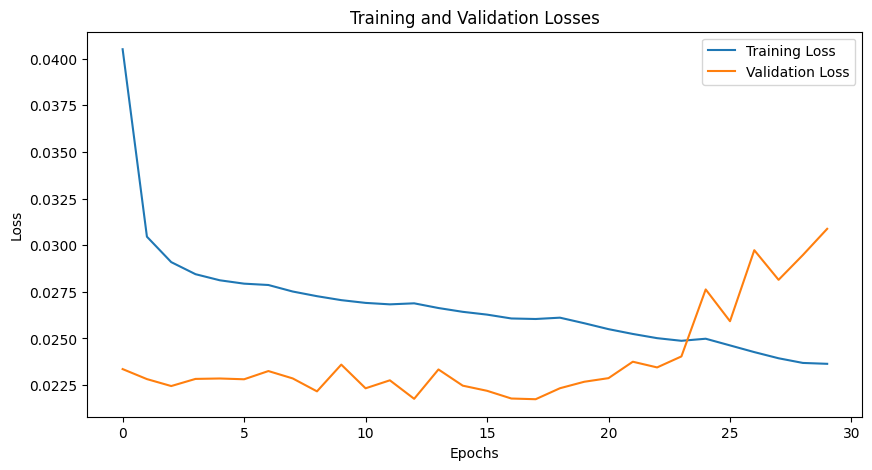

2024-06-19 01:43:46.968694: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-19 01:43:46.968750: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-19 01:43:46.970524: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-19 01:43:48.000232: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to 

In [22]:
# Plotting the losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses')
plt.show()

In [23]:
torch.save(model.state_dict(), "/content/drive/My Drive/AV Research/color_model.pt")

In [ ]:
from google.colab import runtime
runtime.unassign()